## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

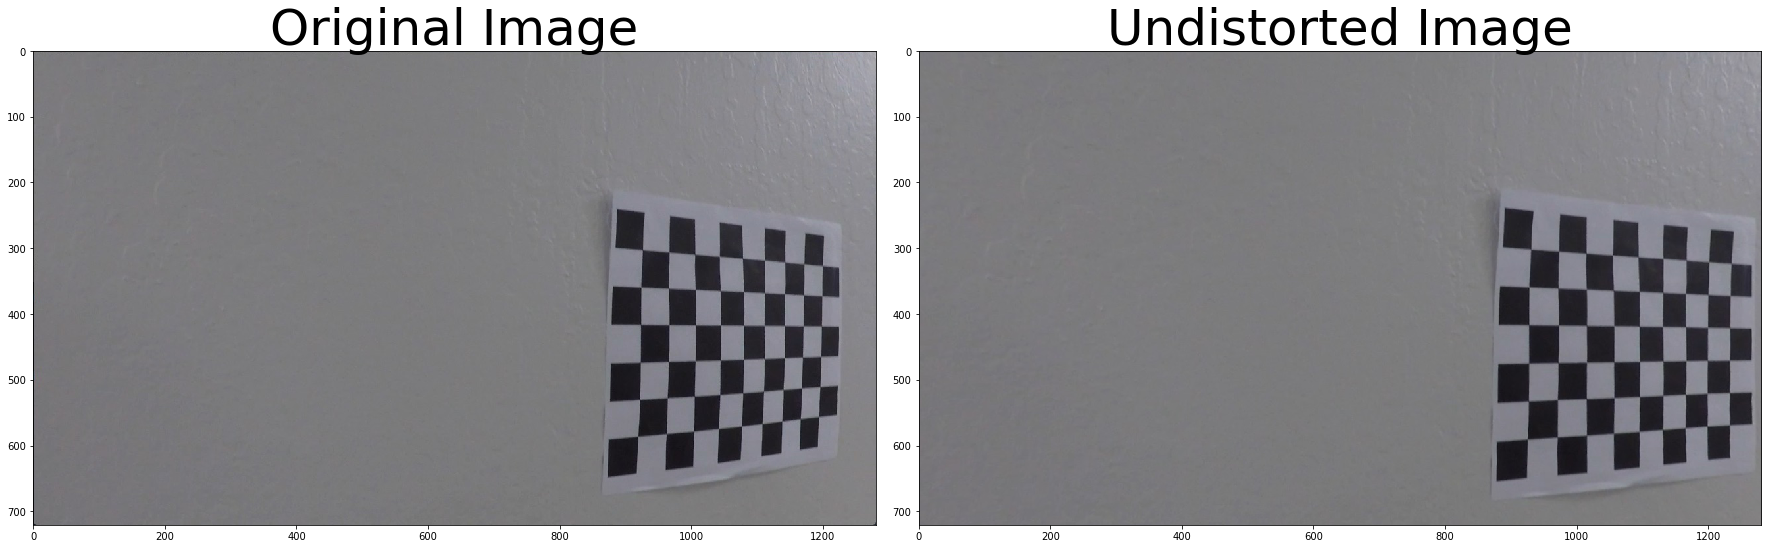

In [54]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #reading in an image
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners - Currently no need for it
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

# Read one image to apply correction and check
test_img = mpimg.imread('./camera_cal/calibration15.jpg')
test_gray = cv2.cvtColor(test_img,cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_gray.shape[::-1], None, None)#

# check the result on test_image
undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#undist = cv2.undistort(img, mtx, dist, None, mtx)
    
#cv2.destroyAllWindows()

## Apply a distortion correction to raw images.

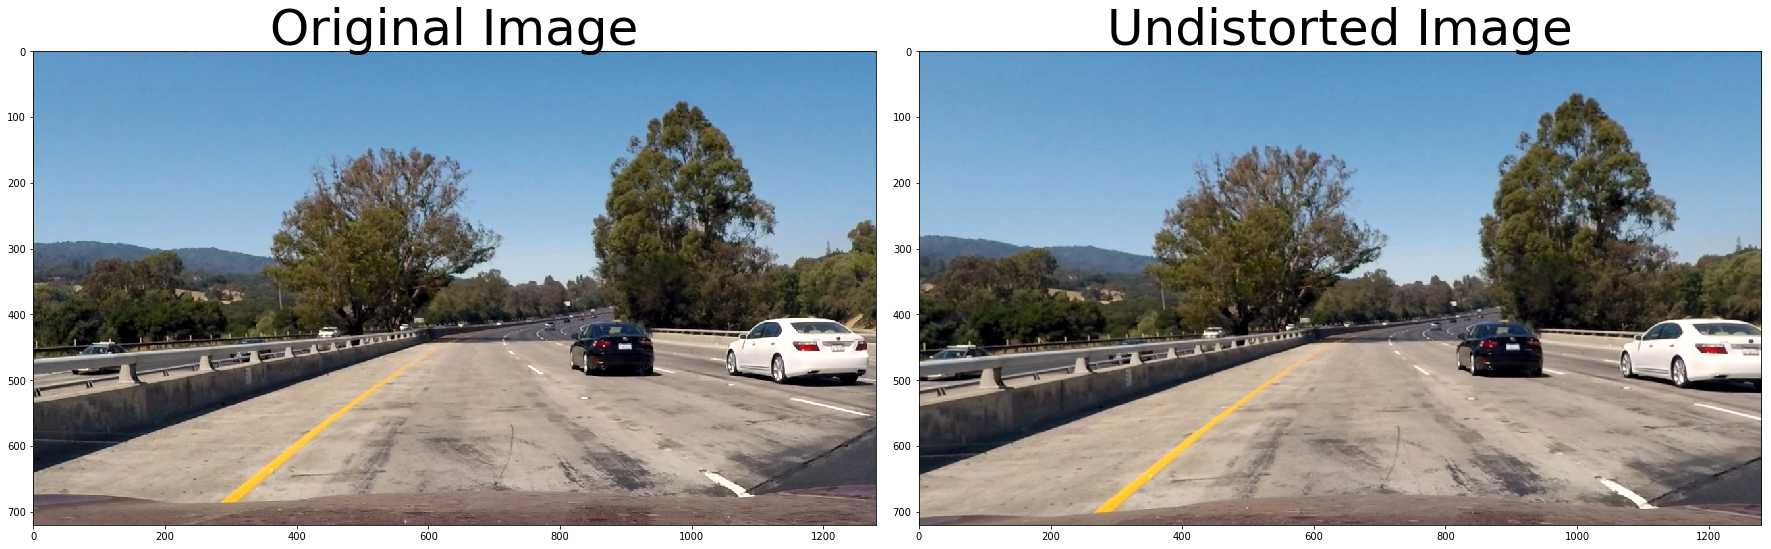

In [55]:
def distort_correct(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)
# Read one image to apply correction and check
rimg = mpimg.imread('./test_images/test1.jpg')
undist_rimg = distort_correct(rimg, mtx, dist)

# check the result on raw_image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rimg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_rimg)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image.


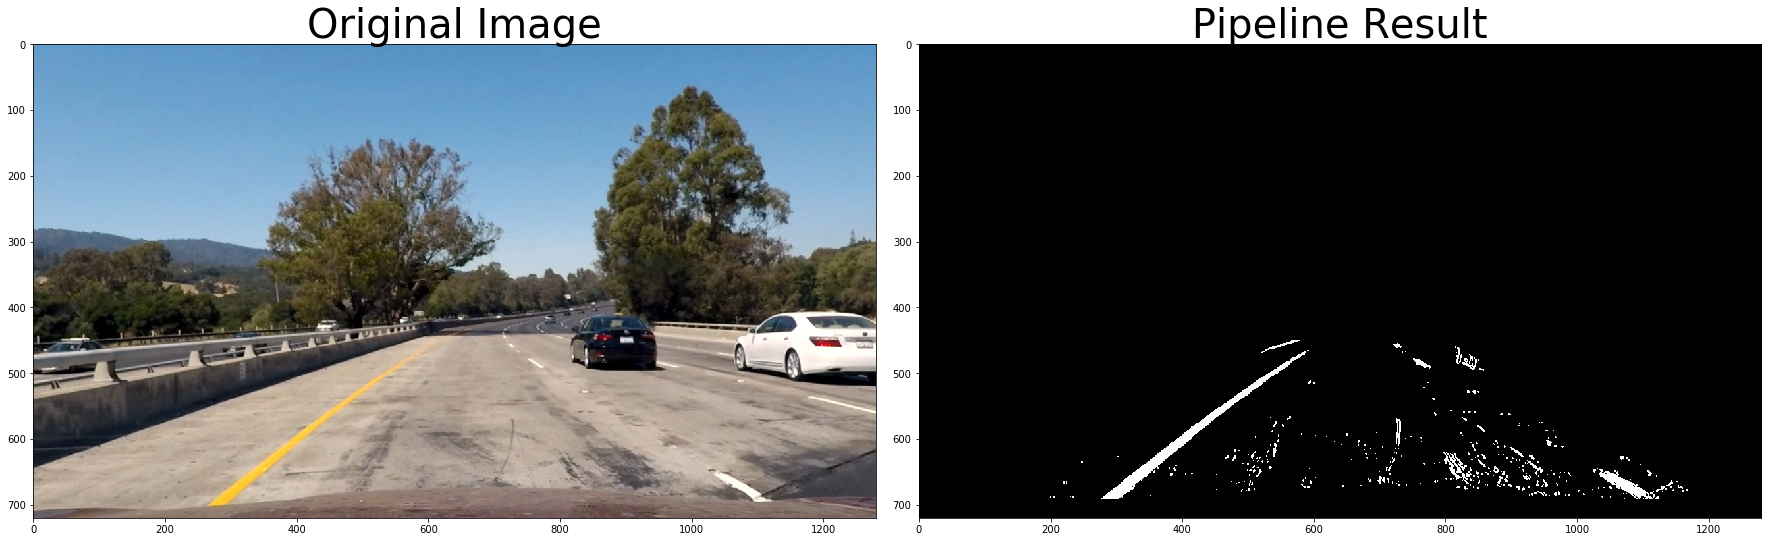

In [56]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def draw_lines_old(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            #print(m)
            if (np.abs(m) > 0.4 and np.abs(m) < 0.9):
                #print(m)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # average slope and y intercept of right line
    m_avg_right = 0
    c_avg_right = 0
    # no of right lines
    n_right_line = 0
    
    # average slope and y intercept of left line
    m_avg_left = 0
    c_avg_left = 0
    # no of left lines
    n_left_line = 0
    #print(np.size(lines))
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            #print(m)
            c = y1-(m*x1)
            #for right line
            if (m > 0.4 and m < 0.7):
                m_avg_right = m_avg_right + m
                c_avg_right = c_avg_right + c
                n_right_line = n_right_line + 1
            #for left line
            if (m > -0.9 and m < -0.6):
                m_avg_left = m_avg_left + m
                c_avg_left = c_avg_left + c
                n_left_line = n_left_line + 1
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    #right line
    # initially just add all values and now taking average
    m_avg_right = m_avg_right/n_right_line
    c_avg_right = c_avg_right/n_right_line
    
    #Calculating Points
    y1 = img_height
    x1 = int((y1-c_avg_right)/m_avg_right)
    
    y2 = int(330)
    x2 = int((y2-c_avg_right)/m_avg_right)
    
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    
    #left line
    # initially just add all values and now taking average
    m_avg_left = m_avg_left/n_left_line
    c_avg_left = c_avg_left/n_left_line
    
    #Calculating Points
    y1 = img_height
    x1 = int((y1-c_avg_left)/m_avg_left)
    
    y2 = int(330)
    x2 = int((y2-c_avg_left)/m_avg_left)
    
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_old(line_img, lines)
    return line_img

def simple_thresh(img,thresh=(0, 255)):
    #apply only thresholding on image plane and return binary image
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary

def combine_binary_and(bin1,bin2):
    #combine two binary image with '&' operation
    combined_binary = np.zeros_like(bin1)
    combined_binary[(bin1 == 1) & (bin2 == 1)] = 1
    return combined_binary

def combine_binary_or(bin1,bin2):
    #combine two binary image with '' operation
    combined_binary = np.zeros_like(bin1)
    combined_binary[(bin1 == 1) | (bin2 == 1)] = 1
    return combined_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_orient = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel_orient = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)    
    #Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_orient)
    #Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #Return this mask as your binary_output image
    return sbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sdir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(sdir)
    dir_binary[(sdir >= thresh[0]) & (sdir <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return dir_binary
    
# Edit this function to create your own pipeline.
#def pipeline(img, s_thresh=(180, 255), h_thresh=(15, 40), sx_thresh=(20, 100)):
# h plane is quite sensitive and we have to select very narrow range and both yellow and white appear in that range.
# s plane we can play around in a bigger range while true color appear at higher values 140 seems good choice till now
# if changes require just tune from 140 to maximum 180, no other parameters
# 
def pipeline(img, s_thresh=(140, 255), h_thresh=(15, 40), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # 2- Gaussian smoothing / blurring, video seems also not so sharp so kernel of size 3 would be sufficient
    kernel_size = 3
    l_channel = gaussian_blur(l_channel,kernel_size)
    
    # Sobel x
    gradx_L = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=5, thresh=sx_thresh)
    #dir_binary_L = dir_threshold(l_channel, sobel_kernel=13, thresh=(0.9, 1.1))
    
    #gradx_S = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, thresh=(20, 100))
    #dir_binary_S = dir_threshold(s_channel, sobel_kernel=9, thresh=(0.9, 1.1))
    
    #gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=3, thresh=sx_thresh)
    #grady = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=3, thresh=sx_thresh)
    #mag_binary = mag_thresh(l_channel, sobel_kernel=3, mag_thresh=sx_thresh)
    #dir_binary = dir_threshold(l_channel, sobel_kernel=11, thresh=(0.7, 1.3))
    
    
    
    
    
    # Threshold color channel, aim is to detect yellow
    #h_binary = np.zeros_like(h_channel)
    #h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(gradx), sxbinary, s_binary)) * 255
    #color_binary = np.dstack(( np.zeros_like(gradx), dir_binarys*grads, np.zeros_like(gradx))) * 255
    #color_binary = np.dstack(( np.zeros_like(gradx_L), gradx_S*dir_binary_S + gradx_L*dir_binary_L, np.zeros_like(gradx_L))) * 255
    
    # Threshold color channel
    s_binary = simple_thresh(s_channel,s_thresh)
    h_binary = simple_thresh(h_channel,h_thresh)
    
    combined_sh = combine_binary_and(s_binary,h_binary)
    combined_binary = combine_binary_or(combined_sh,gradx_L)
    #combined_binary[(gradx_L == 1) & (dir_binary_L == 1)] = 1
    
    # 4- Defining a four sided polygon to mask
    imshape = combined_binary.shape
    vertices = np.array([[(150,imshape[0]-30),(550, 450), (800, 450), (imshape[1]-80,imshape[0]-30)]], dtype=np.int32)
    #edges = np.dstack(( combined_binary, combined_binary , combined_binary)) * 255
    #edges = np.uint8(edges)
    roi_edges = region_of_interest(np.uint8(combined_binary*255), vertices)
    #print(roi_edges.shape)
    # Save the result
    #mpimg.imsave('test_images_output/roi_edges.jpg',roi_edges,cmap='gray')
    
    #color_binary = np.dstack(( np.zeros_like(gradx_L), combined_binary , roi_edges)) * 255
    #**********at last do combined binary like this
    #combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #return color_binary.astype(np.uint8) 
    
    #kernel = np.ones((3,3),np.uint8)
    #in_hough = cv2.erode(roi_edges,kernel,iterations = 1)
    
    #kernel = np.ones((3,3),np.uint8)
    #in_hough = cv2.dilate(in_hough,kernel,iterations = 1)
    #in_hough = roi_edges
    # 5- Apply Hough Transformation
    #rho = 1 # distance resolution in pixels of the Hough grid
    #theta = np.pi/180 # angular resolution in radians of the Hough grid
    #threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    #min_line_len = 100 #minimum number of pixels making up a line
    #max_line_gap = 200    # maximum gap in pixels between connectable line segments
    #line_img = hough_lines(in_hough, rho, theta, threshold, min_line_len, max_line_gap)
    
    roi_binary = np.zeros_like(roi_edges)
    roi_binary[roi_edges > 127] = 1
    
    #hough_binary = np.zeros_like(line_img[:,:,0])
    #hough_binary[line_img[:,:,0] > 127] = 1
    #final_binary = combine_binary_or(combined_binary,hough_binary)
    
    #kernel = np.ones((3,3),np.uint8)
    #dilation = cv2.dilate(roi_binary,kernel,iterations = 2)
    
    #kernel = np.ones((3,3),np.uint8)
    #erosion = cv2.erode(dilation,kernel,iterations = 3)
    
    #kernel = np.ones((3,3),np.uint8)
    #roi_binary = cv2.dilate(erosion,kernel,iterations = 1)


    return np.uint8(np.dstack(( roi_binary, roi_binary , roi_binary)) * 255)
    
rimg_binary = pipeline(undist_rimg)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_rimg)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(rimg_binary)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view").

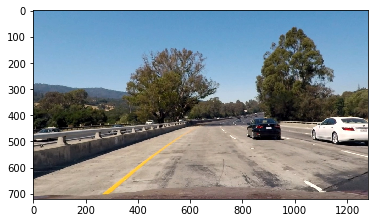

In [57]:
%matplotlib inline
plt.imshow(undist_rimg)


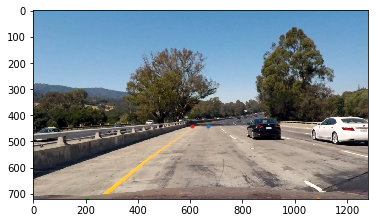

In [58]:
%matplotlib inline
plt.imshow(undist_rimg)
plt.plot(670,442,'.') #top right
plt.plot(1089,719,'.')  #bottom right
plt.plot(207,719,'.') #bottom left
plt.plot(608,442,'.') #top left

Text(0.5,1,'Undistorted and Warped Image')

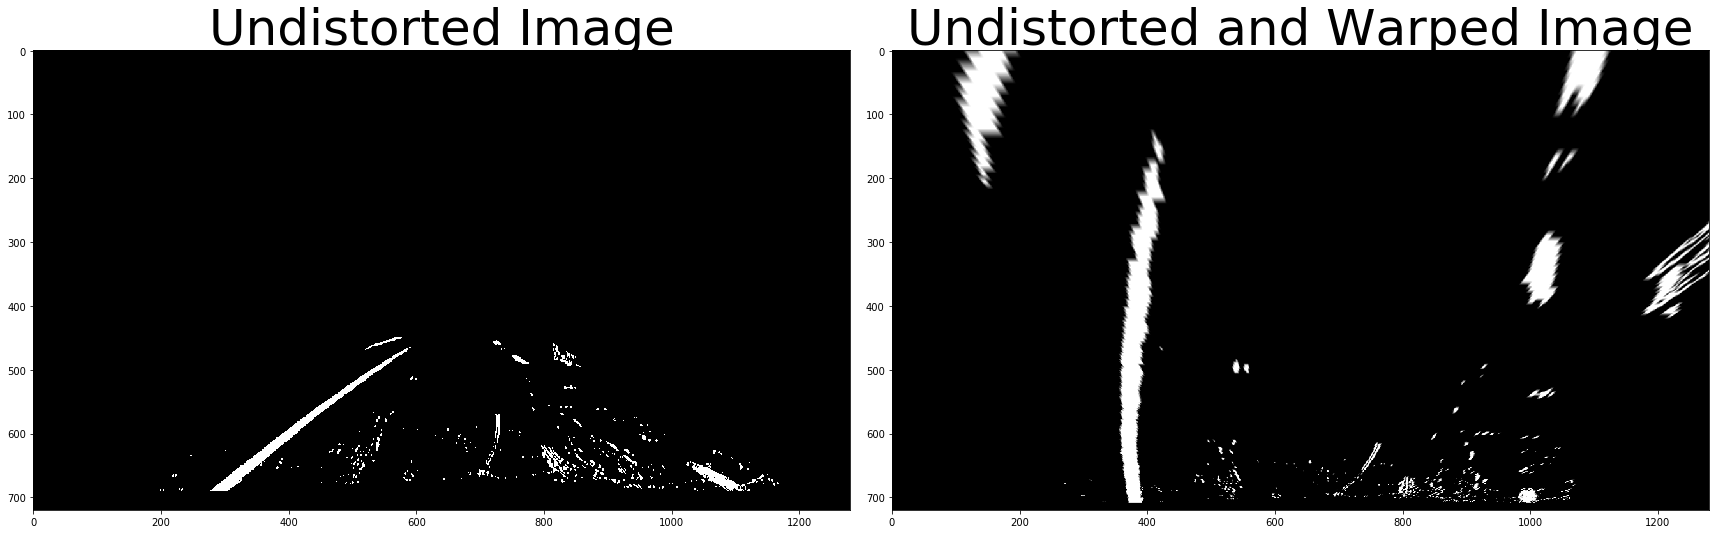

In [59]:
def wrap_perspectTransform(img,M):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size)
%matplotlib inline

src_corners = []
src_corners.append([714,467]) #top right
src_corners.append([1089,719]) #bottom right
src_corners.append([207,719]) #bottom left
src_corners.append([572,467]) #top left
#src_corners.append([877,567]) #top right
#src_corners.append([1075,691]) #bottom right
#src_corners.append([247,691]) #bottom left
#src_corners.append([422,567]) #top left



dst_corners = []
dst_corners.append([950,180]) #top right
dst_corners.append([950,719]) #bottom right
dst_corners.append([350,719]) #bottom left
dst_corners.append([350,180]) #top left
#dst_corners.append([1075,567]) #top right
#dst_corners.append([1075,691]) #bottom right
#dst_corners.append([247,691]) #bottom left
#dst_corners.append([247,567]) #top left

# For source points I'm grabbing the outer four detected corners
src = np.float32(src_corners)
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32(dst_corners)

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
warped = wrap_perspectTransform(rimg_binary, M)



#kernel = np.ones((3,3),np.uint8)
#warped = cv2.erode(warped,kernel,iterations = 1)

#kernel = np.ones((3,3),np.uint8)
#warped = cv2.dilate(warped,kernel,iterations = 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rimg_binary)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)



## Detect lane pixels and fit to find the lane boundary.

In [61]:
## Implement Sliding Windows and Fit a Polynomial


def slidingwindow_polyfit(binary,nwindows,margin,minpix):
    #binary_warped = warped[:,:,0]
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary[np.uint8(binary.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary, binary, binary))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    #nwindows = 9
    # Set height of windows
    window_height = np.int(binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, leftx, lefty, right_fit, rightx, righty, out_img

#just to make sure that this warping does not
binary_warped = np.zeros_like(warped[:,:,0])
binary_warped[warped[:,:,0] >= 128] = 1
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
left_fit, leftx, lefty, right_fit, rightx, righty, out_img = slidingwindow_polyfit(binary_warped,nwindows,margin,minpix)

In [76]:
## Look-Ahead Filter

def lookAhead_polyfit(binary,prev_left_fit, prev_right_fit, nwindows,margin,minpix):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #margin = 100
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, leftx, lefty, right_fit, rightx, righty, out_img

(720, 0)

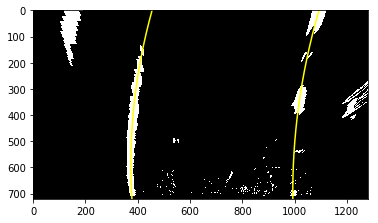

In [77]:
## Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

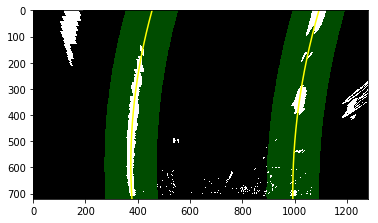

In [78]:
## And you're done! But let's visualize the result here as well
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)


# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Define y-value where we want radius of curvature


In [102]:
def find_curvature(binary,lefty,leftx,righty,rightx):
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    # Define conversions in x and y from pixels space to meters
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.0/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

left_curverad, right_curverad = find_curvature(binary_warped,lefty,leftx,righty,rightx)
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m



599.253337774 m 674.895939242 m


## Create an image to draw the lines on


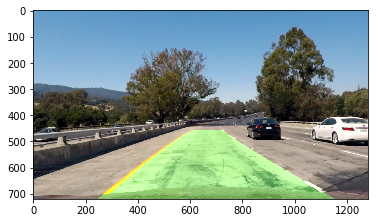

In [80]:
def plot_result(img,ploty,left_fitx,right_fitx,M):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = wrap_perspectTransform(color_warp,Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
result_img = plot_result(undist_rimg,ploty,left_fitx,right_fitx,M)
plt.imshow(result_img)

In [138]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients for the most recent n fits
        self.recent_fits = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        #decision whether to append or use idx to put the new value
        self.append = True
        
        #current index in the arrays
        self.idx = 0
        
        #reset_counter
        self.rst_cnt = 0

In [148]:
left_line = Line()
right_line = Line()
N = 10 # no of iteration to consider for the final result calculation
frame = 0
sanity_check_en = False
reset = False

#Sanity Check
#each line is taken if it's radius of curvature is within (1-rad_bound)*previous_rad and (1+rad_bound)*previous_rad
rad_bound = 0.4
rst_rad_bound = 5 # reset to take fresh measurements after 5 successive failed frames

def process_image(img_c):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global frame, reset, sanity_check_en
    undist_rimg_c = distort_correct(img_c, mtx, dist)
    rimg_binary_c = pipeline(undist_rimg_c)
    warped_c = wrap_perspectTransform(rimg_binary_c, M)
    
    binary_warped_c = np.zeros_like(warped_c[:,:,0])
    binary_warped_c[warped_c[:,:,0] >= 128] = 1
    
    if (frame == 0) or reset:
        left_fit_c, leftx_c, lefty_c, right_fit_c, rightx_c, righty_c, out_img = slidingwindow_polyfit(binary_warped_c,nwindows,margin,minpix)
        reset = False
        #print(frame)
    else:
        #print(frame)
        left_fit_c, leftx_c, lefty_c, right_fit_c, rightx_c, righty_c, out_img = lookAhead_polyfit(binary_warped_c,left_line.current_fit[0], right_line.current_fit[0], nwindows,margin,minpix)
    
    left_curverad, right_curverad = find_curvature(binary_warped_c,lefty_c,leftx_c,righty_c,rightx_c)
    print(left_curverad, right_curverad)
    
    ploty_c = np.linspace(0, img_c.shape[0]-1, img_c.shape[0] )
    left_fitx_c = left_fit_c[0]*ploty_c**2 + left_fit_c[1]*ploty_c + left_fit_c[2]
    right_fitx_c = right_fit_c[0]*ploty_c**2 + right_fit_c[1]*ploty_c + right_fit_c[2]
    
    if (sanity_check_en):
        # put sanity check on the average polynomial parameters instead
        if left_curverad > (1-rad_bound)*left_line.radius_of_curvature and left_curverad < (1+rad_bound)*left_line.radius_of_curvature:
            left_line.detected = True
        else:
            left_line.detected = False
            left_line.rst_cnt = left_line.rst_cnt+1
            if left_line.rst_cnt == rst_rad_bound:
                reset = True
                left_line.rst_cnt = 0
        print(left_line.detected)
        
        if right_curverad > (1-rad_bound)*right_line.radius_of_curvature and right_curverad < (1+rad_bound)*right_line.radius_of_curvature:
            right_line.detected = True
        else:
            right_line.detected = False
            right_line.rst_cnt = right_line.rst_cnt+1
            if right_line.rst_cnt == rst_rad_bound:
                reset = True
                right_line.rst_cnt = 0
        print(right_line.detected)
    else:
        left_line.detected = True
        right_line.detected = True
        sanity_check_en = True
        
    if left_line.detected:
        if left_line.append:
            left_line.recent_xfitted.append(left_fitx_c)
            left_line.recent_fits.append(left_fit_c)
        else:
            left_line.recent_xfitted[left_line.idx] = left_fitx_c
            left_line.recent_fits[left_line.idx] = left_fit_c
        left_line.bestx = np.sum(left_line.recent_xfitted,axis=0)/np.shape(left_line.recent_xfitted)[0]
        left_line.current_fit[0] = left_fit_c
        left_line.best_fit = np.sum(left_line.recent_fits,axis=0)/np.shape(left_line.recent_fits)[0]
        left_line.radius_of_curvature = left_curverad
        
        left_line.idx = left_line.idx + 1
        if left_line.idx == N:
            left_line.append = False
            left_line.idx = 0
            
        
    if right_line.detected:
        if right_line.append:
            right_line.recent_xfitted.append(right_fitx_c)
            right_line.recent_fits.append(right_fit_c)
        else:
            right_line.recent_xfitted[right_line.idx] = right_fitx_c
            right_line.recent_fits[right_line.idx] = right_fit_c
        right_line.bestx = np.sum(right_line.recent_xfitted,axis=0)/np.shape(right_line.recent_xfitted)[0]
        right_line.current_fit[0] = right_fit_c
        right_line.best_fit = np.sum(right_line.recent_fits,axis=0)/np.shape(right_line.recent_fits)[0]
        right_line.radius_of_curvature = right_curverad
        
        right_line.idx = right_line.idx + 1
        if right_line.idx == N:
            right_line.append = False
            right_line.idx = 0
    
    if reset: # flush the history only keep important things like curvature
        left_line.idx = 0
        right_line.idx = 0
        
        left_line.append = True
        right_line.append = True
        
        left_line.recent_xfitted = []
        right_line.recent_xfitted = []
        
        sanity_check_en = False
    
    result_c = plot_result(undist_rimg_c,ploty_c,left_line.bestx,right_line.bestx,M)
    
    #mpimg.imsave('project_video_output/frame'+str(frame)+'.jpg',result_c)
    frame = frame + 1
    return result_c

In [149]:
# Import everything needed to edit/save/watch video clips
count = 0

def save_image(img_c):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global count
    count = count+1
    #mpimg.imsave('harder_challenge_video/frame'+str(count)+'.jpg',img_c)
    
    return img_c

In [150]:
white_output = './project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

488.185249413 415.058720375
[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

488.73397931 415.058720375
True
True



  0%|          | 2/1261 [00:00<04:30,  4.65it/s]

476.140720188 422.842088819
True
True
493.412294256 529.140633157
True
True



  0%|          | 5/1261 [00:00<04:01,  5.21it/s]

479.570823593 750.46764163
True
False
517.094431159 1011.71598394
True
False



  0%|          | 6/1261 [00:01<03:56,  5.30it/s]

523.183161902 1291.72481454
True
False
535.562783709 1354.90648009
True
False



  1%|          | 8/1261 [00:01<03:49,  5.47it/s]

562.526733446 993.296920863
True
False
604.234443934 992.133139371



  1%|          | 10/1261 [00:01<03:50,  5.42it/s]

604.910734172 2459.70165328
True
False
652.71029746 1305.69198947
True
True



  1%|          | 12/1261 [00:02<04:01,  5.17it/s]

667.324617213 2673.71816283
True
False



  1%|          | 13/1261 [00:02<04:14,  4.90it/s]

752.2641607 520.635916308
True
False
748.918086837 474.847077923
True
False



  1%|          | 15/1261 [00:02<04:18,  4.82it/s]

793.01639335 635.170071377
True
False



  1%|▏         | 16/1261 [00:03<04:21,  4.77it/s]

811.143253919 1091.77362808



  1%|▏         | 17/1261 [00:03<04:19,  4.79it/s]

795.540443814 1230.33985471
True
True



  1%|▏         | 18/1261 [00:03<04:28,  4.64it/s]

808.528272132 788.563909861
True
True



  2%|▏         | 19/1261 [00:03<04:29,  4.60it/s]

828.009594441 944.951798168
True
True



  2%|▏         | 20/1261 [00:04<04:31,  4.58it/s]

908.318749829 762.772544628
True
True
924.37551397 780.310431907
True
True



  2%|▏         | 22/1261 [00:04<04:05,  5.04it/s]

911.076486478 732.836133024
True
True
896.44600261 707.535706803
True
True



  2%|▏         | 24/1261 [00:04<04:12,  4.90it/s]

834.172358756 1240.80073956
True
False
719.404468889 494.345522988
True
True



  2%|▏         | 26/1261 [00:05<04:01,  5.12it/s]

745.312271828 480.719565419
True
True
677.205902133 398.665798317
True
True



  2%|▏         | 28/1261 [00:05<03:55,  5.24it/s]

672.463322423 459.391879986
True
True
705.325601273 438.355972428
True
True



  2%|▏         | 30/1261 [00:05<03:55,  5.22it/s]

662.997286776 638.284779666
True
False
608.346211871 1023.19303316
True
False



  3%|▎         | 32/1261 [00:06<03:48,  5.37it/s]

542.23776095 1112.07007571
True
False
525.154044465 859.060225212
True
False



  3%|▎         | 35/1261 [00:06<03:46,  5.42it/s]

480.414423458 571.065966503
464.440966273 705.257770196
True
True



  3%|▎         | 36/1261 [00:07<03:44,  5.46it/s]

445.916295886 451.045501562
True
True



  3%|▎         | 37/1261 [00:07<04:01,  5.07it/s]

431.763049819 343.912807837
True
True



  3%|▎         | 38/1261 [00:07<04:10,  4.88it/s]

396.342373833 332.630570673
True
True
385.410793503 437.075328382
True
True



  3%|▎         | 40/1261 [00:07<04:05,  4.96it/s]

397.184160702 461.697160674
True
True



  3%|▎         | 41/1261 [00:08<04:19,  4.70it/s]

391.940102406 560.240104617
True
True



  3%|▎         | 42/1261 [00:08<04:21,  4.67it/s]

415.130840379 653.684072076
True
True



  3%|▎         | 43/1261 [00:08<04:27,  4.56it/s]

432.839009438 678.398646561
True
True



  3%|▎         | 44/1261 [00:08<04:29,  4.52it/s]

469.958958786 719.822974692
True
True



  4%|▎         | 45/1261 [00:08<04:27,  4.54it/s]

462.04881301 769.116388977
True
True
456.454167785 500.36373887
True
True



  4%|▎         | 47/1261 [00:09<04:11,  4.83it/s]

469.385197824 646.288118095
True
True



  4%|▍         | 48/1261 [00:09<04:16,  4.72it/s]

492.123085287 673.825167838
True
True



  4%|▍         | 49/1261 [00:09<04:20,  4.66it/s]

532.768950659 794.173384866
True
True



  4%|▍         | 50/1261 [00:10<04:33,  4.43it/s]

551.446285934 459.225195328
True
False



  4%|▍         | 51/1261 [00:10<04:42,  4.28it/s]

570.80914156 363.603242026
True
False
591.526633616 382.895149115
True
False



  4%|▍         | 53/1261 [00:10<04:35,  4.38it/s]

671.925164701 505.082334899
True
True



  4%|▍         | 54/1261 [00:10<04:36,  4.37it/s]

660.156003497 632.238905464
True
True



  4%|▍         | 55/1261 [00:11<04:33,  4.40it/s]

760.392998247 682.756539881
True
True



  4%|▍         | 56/1261 [00:11<04:40,  4.30it/s]

803.006017245 816.236135673
True
True



  5%|▍         | 57/1261 [00:11<04:45,  4.21it/s]

789.252379972 692.476987125
True
True
770.475015632 641.453083313
True
True



  5%|▍         | 59/1261 [00:12<04:39,  4.31it/s]

680.762150208 910.106643839
True
False



  5%|▍         | 60/1261 [00:12<04:42,  4.25it/s]

630.841095221 585.419479512
True
True



  5%|▍         | 61/1261 [00:12<04:33,  4.39it/s]

681.670870022 394.028405184
True
True



  5%|▍         | 62/1261 [00:12<04:39,  4.29it/s]

600.590626032 513.278327854
True
True
603.048260472


  5%|▌         | 64/1261 [00:13<04:20,  4.60it/s]

 556.848744184
True
True
583.424376156 823.711813044
True
False



  5%|▌         | 65/1261 [00:13<04:20,  4.59it/s]

677.338472069 843.081728484



  5%|▌         | 66/1261 [00:13<04:25,  4.50it/s]

666.377963535 978.713985899
True
True



  5%|▌         | 67/1261 [00:13<04:34,  4.35it/s]

664.935023735 907.956322597
True
True



  5%|▌         | 68/1261 [00:14<04:30,  4.41it/s]

756.33145991 803.243988557
True
True
745.23998578


  6%|▌         | 70/1261 [00:14<04:21,  4.55it/s]

 677.226804957
True
True
770.644905375 706.792092698
True
True



  6%|▌         | 71/1261 [00:14<04:25,  4.48it/s]

754.616364313 440.118694765
True
True



  6%|▌         | 72/1261 [00:15<04:20,  4.57it/s]

838.843352815 397.81824192
True
True



  6%|▌         | 73/1261 [00:15<04:19,  4.58it/s]

877.108818978 347.149884963
True
True



  6%|▌         | 74/1261 [00:15<04:22,  4.52it/s]

902.027522061 318.895740108
True
True



  6%|▌         | 75/1261 [00:15<04:17,  4.60it/s]

991.172126518 349.412202642
True
True



  6%|▌         | 76/1261 [00:15<04:14,  4.66it/s]

976.416278635 392.078788858
True
True
1119.50256279


  6%|▌         | 78/1261 [00:16<04:11,  4.70it/s]

 402.450914349
True
True
1224.84370416 462.74923821
True
True



  6%|▋         | 79/1261 [00:16<04:10,  4.72it/s]

1328.88287401 525.963348854
True
True



  6%|▋         | 80/1261 [00:16<04:12,  4.67it/s]

1272.97577769 655.060300966
True
True



  6%|▋         | 81/1261 [00:16<04:24,  4.46it/s]

1321.94945997 842.192941196
True
True



  7%|▋         | 82/1261 [00:17<04:23,  4.48it/s]

1168.98407431 1109.39963201
True
True



  7%|▋         | 83/1261 [00:17<04:20,  4.52it/s]

1048.77867786 956.994651321
True
True



  7%|▋         | 84/1261 [00:17<04:18,  4.56it/s]

1061.05643659 11724.1430649
True
False



  7%|▋         | 85/1261 [00:17<04:34,  4.29it/s]

902.719544905 882.003451748
True
True



  7%|▋         | 86/1261 [00:18<04:32,  4.32it/s]

814.121075016 1016.78754103
True
True
654.051248138


  7%|▋         | 88/1261 [00:18<04:17,  4.55it/s]

 561.665830732
True
False
551.734225265 405.855837975
True
False



  7%|▋         | 89/1261 [00:18<04:33,  4.29it/s]

544.603923474 501.983203058
True
False



  7%|▋         | 90/1261 [00:19<04:29,  4.35it/s]

529.334210025 760.180065096
True
True



  7%|▋         | 91/1261 [00:19<04:22,  4.45it/s]

536.248166515 834.352237918
True
True



  7%|▋         | 92/1261 [00:19<04:24,  4.42it/s]

535.203931875 885.09036107
True
True



  7%|▋         | 93/1261 [00:19<04:35,  4.24it/s]

557.564904977 823.38403982
True
True



  7%|▋         | 94/1261 [00:19<04:27,  4.36it/s]

542.693657105 684.65612564
True
True



  8%|▊         | 95/1261 [00:20<04:22,  4.43it/s]

560.903868868 701.326284692
True
True



  8%|▊         | 96/1261 [00:20<04:27,  4.36it/s]

593.328212268 690.151782927
True
True



  8%|▊         | 97/1261 [00:20<04:20,  4.47it/s]

569.738339163 805.74143082
True
True
598.584792775


  8%|▊         | 99/1261 [00:21<04:06,  4.71it/s]

 871.020430329
True
True
644.504676691 394.388188209
True
False



  8%|▊         | 100/1261 [00:21<04:09,  4.65it/s]

603.259372254 372.032293715



  8%|▊         | 101/1261 [00:21<04:06,  4.70it/s]

588.759674558 376.538555768
True
True



  8%|▊         | 102/1261 [00:21<04:09,  4.65it/s]

589.070796228 470.111874603
True
True



  8%|▊         | 103/1261 [00:21<04:07,  4.68it/s]

634.603917859 547.876203162
True
True



  8%|▊         | 104/1261 [00:22<04:05,  4.70it/s]

651.216635562 640.578163769
True
True
682.704960746


  8%|▊         | 106/1261 [00:22<04:00,  4.81it/s]

 694.162632238
True
True
637.084522589 830.433270576
True
True
656.82259764


  9%|▊         | 108/1261 [00:22<04:02,  4.75it/s]

 966.221426128
True
True
576.181758653 684.09087067
True
True
583.300562639 561.077196134
True
True



  9%|▊         | 110/1261 [00:23<03:58,  4.83it/s]

555.910826382 608.879043771
True
True
546.180918936 


  9%|▉         | 112/1261 [00:23<03:59,  4.79it/s]

691.923115693
True
True
559.583856943 687.589367477
True
True
520.378201465 357.494448775
True
False



  9%|▉         | 114/1261 [00:24<03:55,  4.88it/s]

530.522669611 334.507330097
True
False



  9%|▉         | 115/1261 [00:24<03:56,  4.84it/s]

510.827415745 406.749100672
True
False



  9%|▉         | 116/1261 [00:24<04:01,  4.74it/s]

510.777609274 490.727117925
True
True



  9%|▉         | 117/1261 [00:24<04:04,  4.67it/s]

505.76694486 531.685431239
True
True
541.027215838


  9%|▉         | 119/1261 [00:25<04:00,  4.75it/s]

 621.496038913
True
True
539.086708327 576.179002865
True
True
491.953066857 504.519241461
True
True



 10%|▉         | 121/1261 [00:25<03:55,  4.85it/s]

519.887589953 510.9215026
True
True
483.554867262 669.016284628
True
True



 10%|▉         | 123/1261 [00:26<03:50,  4.93it/s]

469.537065783 314.851268695
True
False
456.287867961 305.329671106
True
False



 10%|▉         | 125/1261 [00:26<03:49,  4.95it/s]

465.97517475 338.824959043



 10%|▉         | 126/1261 [00:26<03:52,  4.87it/s]

480.599045602 368.869136411
True
True



 10%|█         | 127/1261 [00:26<04:01,  4.70it/s]

464.117040919 454.102226914
True
True



 10%|█         | 128/1261 [00:27<04:08,  4.57it/s]

487.593581139 493.566891495
True
True



 10%|█         | 129/1261 [00:27<04:07,  4.58it/s]

487.263116623 617.510692235
True
True



 10%|█         | 130/1261 [00:27<04:07,  4.57it/s]

535.236784553 636.210680653
True
True



 10%|█         | 131/1261 [00:27<04:04,  4.62it/s]

531.222824962 508.626224777
True
True



 10%|█         | 132/1261 [00:27<04:08,  4.53it/s]

519.209877799 494.402259562
True
True



 11%|█         | 133/1261 [00:28<04:09,  4.52it/s]

529.045273392 535.099295523
True
True



 11%|█         | 134/1261 [00:28<04:09,  4.52it/s]

549.767752057 464.48894494
True
True



 11%|█         | 135/1261 [00:28<04:09,  4.51it/s]

553.449854526 411.129744586
True
True



 11%|█         | 136/1261 [00:28<04:07,  4.54it/s]

564.823996796 399.901344448
True
True



 11%|█         | 137/1261 [00:29<04:06,  4.57it/s]

582.677688269 433.272256032
True
True



 11%|█         | 138/1261 [00:29<04:09,  4.50it/s]

638.308348473 445.978122504
True
True



 11%|█         | 139/1261 [00:29<04:06,  4.56it/s]

656.415623807 487.881714076
True
True



 11%|█         | 140/1261 [00:29<04:05,  4.57it/s]

705.122626987 524.444781393
True
True



 11%|█         | 141/1261 [00:29<04:08,  4.51it/s]

680.87756724 616.693838323
True
True



 11%|█▏        | 142/1261 [00:30<04:07,  4.53it/s]

743.904049701 749.719976683
True
True



 11%|█▏        | 143/1261 [00:30<04:09,  4.49it/s]

711.486120748 1082.34528358
True
False



 11%|█▏        | 144/1261 [00:30<04:10,  4.45it/s]

723.285517236 922.700448477
True
True



 11%|█▏        | 145/1261 [00:30<04:06,  4.52it/s]

730.712783698 692.3425703
True
True



 12%|█▏        | 146/1261 [00:31<04:06,  4.53it/s]

715.829756637 704.599243799
True
True



 12%|█▏        | 147/1261 [00:31<04:06,  4.53it/s]

744.162796091 705.480669789
True
True



 12%|█▏        | 148/1261 [00:31<04:06,  4.52it/s]

662.780907821 335.980173183
True
False



 12%|█▏        | 149/1261 [00:31<04:04,  4.54it/s]

659.040020352 348.819522778
True
False



 12%|█▏        | 150/1261 [00:31<04:04,  4.54it/s]

676.098705794 404.883371127
True
False



 12%|█▏        | 151/1261 [00:32<04:02,  4.57it/s]

677.128061621 404.282061984
True
False



 12%|█▏        | 152/1261 [00:32<04:09,  4.44it/s]

705.413629446 472.544529397



 12%|█▏        | 153/1261 [00:32<04:07,  4.47it/s]

685.024657026 687.454183007
True
False



 12%|█▏        | 154/1261 [00:32<04:07,  4.47it/s]

733.314041651 711.061097347
True
False



 12%|█▏        | 155/1261 [00:33<04:04,  4.53it/s]

793.610039649 793.586964509
True
False



 12%|█▏        | 156/1261 [00:33<04:02,  4.55it/s]

755.198036862 987.387837979
True
False



 12%|█▏        | 157/1261 [00:33<04:02,  4.56it/s]

735.830935368 848.165946466
True
False



 13%|█▎        | 158/1261 [00:33<04:02,  4.55it/s]

666.638487246 855.452028794



 13%|█▎        | 159/1261 [00:33<03:59,  4.60it/s]

667.24536212 1092.54103992
True
True



 13%|█▎        | 160/1261 [00:34<04:00,  4.58it/s]

621.483195982 748.982113724
True
True



 13%|█▎        | 161/1261 [00:34<04:00,  4.58it/s]

597.305645921 561.195279788
True
True



 13%|█▎        | 162/1261 [00:34<04:00,  4.56it/s]

589.841344059 511.484586597
True
True



 13%|█▎        | 163/1261 [00:34<03:59,  4.58it/s]

581.658761324 454.683141934
True
True



 13%|█▎        | 164/1261 [00:35<03:56,  4.64it/s]

576.367986806 498.603843778
True
True



 13%|█▎        | 165/1261 [00:35<03:58,  4.59it/s]

576.956120624 638.88663139
True
True



 13%|█▎        | 166/1261 [00:35<03:58,  4.59it/s]

605.779132061 768.259708944
True
True



 13%|█▎        | 167/1261 [00:35<03:59,  4.57it/s]

606.604983775 670.871982038
True
True



 13%|█▎        | 168/1261 [00:35<03:57,  4.59it/s]

695.866779561 731.515460953
True
True



 13%|█▎        | 169/1261 [00:36<03:56,  4.61it/s]

745.281906149 745.961612751
True
True



 13%|█▎        | 170/1261 [00:36<03:56,  4.62it/s]

766.458368561 624.369539764
True
True



 14%|█▎        | 171/1261 [00:36<03:56,  4.60it/s]

745.058698616 405.315340053
True
True



 14%|█▎        | 172/1261 [00:36<03:56,  4.60it/s]

726.201462302 397.122427184
True
True
674.844053804


 14%|█▍        | 174/1261 [00:37<03:49,  4.74it/s]

 260.984599315
True
True
626.817205303 238.332595577
True
True
593.852773731 290.325803818


 14%|█▍        | 176/1261 [00:37<03:45,  4.80it/s]


True
True
561.758017586 312.520081714
True
True
576.69075944 331.988881462
True
True



 14%|█▍        | 178/1261 [00:38<03:44,  4.82it/s]

576.907318363 354.957071517
True
True
579.944898366 395.335615303
True
True



 14%|█▍        | 180/1261 [00:38<03:42,  4.87it/s]

580.501675539 432.189070596
True
True



 14%|█▍        | 181/1261 [00:38<03:44,  4.80it/s]

544.727855917 379.952091
True
True



 14%|█▍        | 182/1261 [00:38<03:49,  4.70it/s]

534.440149341 420.348626764
True
True



 15%|█▍        | 183/1261 [00:39<03:49,  4.70it/s]

462.28566856 480.378368203
True
True



 15%|█▍        | 184/1261 [00:39<03:51,  4.65it/s]

443.601527515 358.242094676
True
True



 15%|█▍        | 185/1261 [00:39<03:57,  4.53it/s]

422.873082873 302.862152273
True
True



 15%|█▍        | 186/1261 [00:39<03:57,  4.52it/s]

375.09435279 416.594570972
True
True



 15%|█▍        | 187/1261 [00:39<03:55,  4.56it/s]

366.606820764 451.124421944
True
True



 15%|█▍        | 188/1261 [00:40<03:55,  4.56it/s]

355.733487236 527.852473998
True
True



 15%|█▍        | 189/1261 [00:40<04:00,  4.47it/s]

363.766755629 438.865371069
True
True



 15%|█▌        | 190/1261 [00:40<04:00,  4.46it/s]

379.722311543 428.805683946
True
True



 15%|█▌        | 191/1261 [00:40<03:58,  4.49it/s]

389.190052755 415.703039912
True
True



 15%|█▌        | 192/1261 [00:41<03:56,  4.53it/s]

420.704435714 459.165890723
True
True



 15%|█▌        | 193/1261 [00:41<03:50,  4.64it/s]

436.433200303 376.773698619
True
True



 15%|█▌        | 194/1261 [00:41<03:54,  4.55it/s]

453.963384293 371.606194838
True
True



 15%|█▌        | 195/1261 [00:41<03:55,  4.53it/s]

452.411002244 305.941524986
True
True



 16%|█▌        | 196/1261 [00:41<03:53,  4.56it/s]

527.283364672 625.418426743
True
False



 16%|█▌        | 197/1261 [00:42<03:54,  4.53it/s]

581.547574408 548.297536318
True
False



 16%|█▌        | 198/1261 [00:42<03:57,  4.48it/s]

639.239504755 406.739174595
True
True



 16%|█▌        | 199/1261 [00:42<03:58,  4.46it/s]

672.08357266 595.726223064
True
False



 16%|█▌        | 200/1261 [00:42<03:55,  4.51it/s]

659.939413943 887.473413093
True
False



 16%|█▌        | 201/1261 [00:43<03:54,  4.52it/s]

692.309770398 855.298296986
True
False



 16%|█▌        | 202/1261 [00:43<04:08,  4.26it/s]

650.974300056 403.488161179
630.655061646 437.695286756
True



 16%|█▌        | 204/1261 [00:43<04:00,  4.39it/s]

True
656.608532397 510.413145936
True
True



 16%|█▋        | 205/1261 [00:43<03:54,  4.50it/s]

621.152304429 664.028822971
True
True



 16%|█▋        | 206/1261 [00:44<03:55,  4.48it/s]

598.988154795 658.651325295
True
True



 16%|█▋        | 207/1261 [00:44<03:54,  4.49it/s]

544.854777218 519.554660669
True
True



 16%|█▋        | 208/1261 [00:44<03:52,  4.53it/s]

502.786935328 482.79372079
True
True



 17%|█▋        | 209/1261 [00:44<03:52,  4.53it/s]

507.081395101 467.765345359
True
True



 17%|█▋        | 210/1261 [00:45<03:51,  4.53it/s]

518.074602499 443.289607878
True
True



 17%|█▋        | 211/1261 [00:45<03:52,  4.52it/s]

534.080047563 727.113071778
True
False



 17%|█▋        | 212/1261 [00:45<03:50,  4.55it/s]

493.336027487 419.403766909
True
True



 17%|█▋        | 213/1261 [00:45<03:49,  4.56it/s]

498.988924972 405.431483437
True
True



 17%|█▋        | 214/1261 [00:45<03:47,  4.61it/s]

471.002463217 437.140427122
True
True



 17%|█▋        | 215/1261 [00:46<03:51,  4.53it/s]

479.696873555 576.209883032
True
True



 17%|█▋        | 216/1261 [00:46<03:51,  4.51it/s]

500.763101978 707.951623217
True
True



 17%|█▋        | 217/1261 [00:46<03:52,  4.50it/s]

504.128234817 847.271929418
True
True



 17%|█▋        | 218/1261 [00:46<03:52,  4.49it/s]

534.489049499 1060.94096489
True
True



 17%|█▋        | 219/1261 [00:47<03:51,  4.50it/s]

521.406453048 705.45040094
True
True



 17%|█▋        | 220/1261 [00:47<03:57,  4.39it/s]

560.745793522 878.925014592
True
True



 18%|█▊        | 221/1261 [00:47<03:58,  4.36it/s]

572.204295574 798.481786822
True
True



 18%|█▊        | 222/1261 [00:47<03:53,  4.45it/s]

582.281623537 1076.28029826
True
True



 18%|█▊        | 223/1261 [00:47<03:49,  4.52it/s]

578.817975524 1051.0810661
True
True



 18%|█▊        | 224/1261 [00:48<03:49,  4.52it/s]

575.417421808 422.941794406
True
False



 18%|█▊        | 225/1261 [00:48<03:48,  4.53it/s]

604.761550537 427.8861723
True
False



 18%|█▊        | 226/1261 [00:48<03:48,  4.53it/s]

593.585776024 534.414419489
True
False



 18%|█▊        | 227/1261 [00:48<03:47,  4.55it/s]

624.315453868 619.614398912
True
False



 18%|█▊        | 228/1261 [00:49<03:46,  4.55it/s]

711.996371809 694.746729752



 18%|█▊        | 229/1261 [00:49<03:48,  4.51it/s]

717.153186337 882.685159768
True
True



 18%|█▊        | 230/1261 [00:49<03:46,  4.54it/s]

764.120250354 884.93877028
True
True



 18%|█▊        | 231/1261 [00:49<03:55,  4.38it/s]

799.184888665 627.326314742
True
True



 18%|█▊        | 232/1261 [00:49<03:50,  4.46it/s]

820.241076466 592.546129802
True
True



 18%|█▊        | 233/1261 [00:50<03:51,  4.45it/s]

809.472233693 489.19759792
True
True



 19%|█▊        | 234/1261 [00:50<03:50,  4.45it/s]

803.303835305 661.225921641
True
True



 19%|█▊        | 235/1261 [00:50<03:51,  4.43it/s]

752.674081078 491.390825917
True
True



 19%|█▊        | 236/1261 [00:50<03:48,  4.48it/s]

701.021740375 311.317362247
True
True



 19%|█▉        | 237/1261 [00:51<03:47,  4.50it/s]

681.854504893 344.267763335
True
True



 19%|█▉        | 238/1261 [00:51<03:48,  4.48it/s]

621.765707422 405.346936044
True
True



 19%|█▉        | 239/1261 [00:51<03:47,  4.50it/s]

570.496766917 462.144704493
True
True



 19%|█▉        | 240/1261 [00:51<03:47,  4.48it/s]

624.056544209 499.082784439
True
True



 19%|█▉        | 241/1261 [00:51<03:48,  4.46it/s]

624.178667576 454.670658873
True
True



 19%|█▉        | 242/1261 [00:52<03:52,  4.39it/s]

645.404265452 483.345367227
True
True



 19%|█▉        | 243/1261 [00:52<03:50,  4.41it/s]

599.388843403 460.899984654
True
True



 19%|█▉        | 244/1261 [00:52<03:46,  4.49it/s]

612.681439441 544.048329567
True
True



 19%|█▉        | 245/1261 [00:52<03:46,  4.48it/s]

573.954771499 284.864401383
True
False



 20%|█▉        | 246/1261 [00:53<03:59,  4.24it/s]

552.366267068 295.623619998
True
False



 20%|█▉        | 247/1261 [00:53<03:57,  4.28it/s]

558.181655037 324.497862558
True
False



 20%|█▉        | 248/1261 [00:53<03:54,  4.32it/s]

529.639082027 424.273441248
True
True



 20%|█▉        | 249/1261 [00:53<04:04,  4.15it/s]

551.800510337 469.559814013
True
True



 20%|█▉        | 250/1261 [00:54<04:02,  4.17it/s]

546.38721382 519.514820071
True
True



 20%|█▉        | 251/1261 [00:54<03:57,  4.25it/s]

564.150664176 567.878934671
True
True



 20%|█▉        | 252/1261 [00:54<04:02,  4.16it/s]

587.061782748 623.879121952
True
True



 20%|██        | 253/1261 [00:54<04:05,  4.11it/s]

600.438027111 556.875947064
True
True



 20%|██        | 254/1261 [00:55<03:58,  4.22it/s]

649.53966036 579.966956623
True
True



 20%|██        | 255/1261 [00:55<03:59,  4.19it/s]

649.682486766 519.666949105
True
True



 20%|██        | 256/1261 [00:55<04:05,  4.09it/s]

642.792533183 531.129266841
True
True



 20%|██        | 257/1261 [00:55<04:00,  4.18it/s]

629.684425217 324.611477833
True
True



 20%|██        | 258/1261 [00:56<03:57,  4.23it/s]

654.236824967 320.03261502
True
True



 21%|██        | 259/1261 [00:56<03:53,  4.29it/s]

647.478216651 324.005838434
True
True



 21%|██        | 260/1261 [00:56<03:52,  4.30it/s]

629.13450478 369.707054789
True
True



 21%|██        | 261/1261 [00:56<03:55,  4.24it/s]

672.230142602 387.473778439
True
True



 21%|██        | 262/1261 [00:56<03:59,  4.17it/s]

700.912229859 472.256638558
True
True



 21%|██        | 263/1261 [00:57<03:57,  4.20it/s]

717.742803734 562.110216083
True
True



 21%|██        | 264/1261 [00:57<03:56,  4.22it/s]

684.43341293 640.85100671
True
True



 21%|██        | 265/1261 [00:57<03:54,  4.25it/s]

710.468079198 677.449008144
True
True



 21%|██        | 266/1261 [00:57<03:50,  4.31it/s]

713.611484975 727.855488456
True
True



 21%|██        | 267/1261 [00:58<03:50,  4.32it/s]

650.012379488 611.162348227
True
True



 21%|██▏       | 268/1261 [00:58<03:47,  4.37it/s]

646.021817357 607.375904764
True
True



 21%|██▏       | 269/1261 [00:58<03:52,  4.26it/s]

683.384812095 635.711870449
True
True



 21%|██▏       | 270/1261 [00:58<03:50,  4.29it/s]

680.32921052 816.932275872
True
True



 21%|██▏       | 271/1261 [00:59<03:45,  4.39it/s]

638.114198454 497.48306428
True
True



 22%|██▏       | 272/1261 [00:59<03:46,  4.37it/s]

602.687629457 415.882205202
True
True



 22%|██▏       | 273/1261 [00:59<03:52,  4.26it/s]

631.929208218 532.719942692
True
True



 22%|██▏       | 274/1261 [00:59<04:02,  4.08it/s]

615.090362334 711.967734073
True
True



 22%|██▏       | 275/1261 [00:59<03:53,  4.22it/s]

620.553100617 848.370931463
True
True



 22%|██▏       | 276/1261 [01:00<03:54,  4.20it/s]

723.560488406 913.773405662
True
True



 22%|██▏       | 277/1261 [01:00<04:03,  4.05it/s]

761.387013788 1064.22055346
True
True



 22%|██▏       | 278/1261 [01:00<03:59,  4.10it/s]

776.385482329 1012.54161029
True
True



 22%|██▏       | 279/1261 [01:00<03:52,  4.21it/s]

804.094359347 759.028422103
True
True



 22%|██▏       | 280/1261 [01:01<03:43,  4.39it/s]

862.30832835 792.302845654
True
True



 22%|██▏       | 281/1261 [01:01<03:40,  4.44it/s]

873.171402806 717.237514002
True
True



 22%|██▏       | 282/1261 [01:01<03:41,  4.42it/s]

855.629859299 485.486394905
True
True



 22%|██▏       | 283/1261 [01:01<03:41,  4.41it/s]

885.622391417 498.132742321
True
True



 23%|██▎       | 284/1261 [01:02<03:37,  4.49it/s]

988.516169704 467.823743704
True
True



 23%|██▎       | 285/1261 [01:02<03:35,  4.54it/s]

1040.06488975 525.331010166
True
True



 23%|██▎       | 286/1261 [01:02<03:35,  4.53it/s]

1105.45104845 570.529760406
True
True



 23%|██▎       | 287/1261 [01:02<03:37,  4.48it/s]

1103.09476893 737.100649058
True
True



 23%|██▎       | 288/1261 [01:02<03:36,  4.49it/s]

1309.05084779 774.388265568
True
True



 23%|██▎       | 289/1261 [01:03<03:34,  4.53it/s]

1255.37705926 1159.55994489
True
False



 23%|██▎       | 290/1261 [01:03<03:37,  4.47it/s]

1389.93077841 1140.4463596
True
False



 23%|██▎       | 291/1261 [01:03<03:38,  4.44it/s]

1148.51537864 845.649504501



 23%|██▎       | 292/1261 [01:03<03:33,  4.53it/s]

1213.8416681 940.929625748
True
True



 23%|██▎       | 293/1261 [01:04<03:31,  4.58it/s]

1218.56038144 935.670267242
True
True



 23%|██▎       | 294/1261 [01:04<03:30,  4.59it/s]

1183.07335611 462.69873151
True
False



 23%|██▎       | 295/1261 [01:04<03:28,  4.63it/s]

1226.31758335 441.207744738
True
False



 23%|██▎       | 296/1261 [01:04<03:42,  4.34it/s]

1204.20091888 523.974937129
True
False



 24%|██▎       | 297/1261 [01:04<03:47,  4.25it/s]

1227.27580558 619.388894893
True
True



 24%|██▎       | 298/1261 [01:05<03:52,  4.14it/s]

1454.22192732 712.512910048
True
True



 24%|██▎       | 299/1261 [01:05<03:47,  4.23it/s]

1463.19186454 875.708161526
True
True



 24%|██▍       | 300/1261 [01:05<03:50,  4.17it/s]

1499.07300982 1091.6310072
True
True



 24%|██▍       | 301/1261 [01:05<03:41,  4.33it/s]

1816.10098561 1612.01559277
True
False



 24%|██▍       | 302/1261 [01:06<03:37,  4.41it/s]

2208.66052721 1948.61157776
True
False



 24%|██▍       | 303/1261 [01:06<03:49,  4.17it/s]

2035.85335907 2306.92345388



 24%|██▍       | 304/1261 [01:06<03:46,  4.22it/s]

1802.11441484 3113.18922749
True
True



 24%|██▍       | 305/1261 [01:06<03:42,  4.29it/s]

1875.59726556 4530.4119333
True
False



 24%|██▍       | 306/1261 [01:07<03:51,  4.12it/s]

1652.05683725 20699.6658938
True
False



 24%|██▍       | 307/1261 [01:07<03:46,  4.21it/s]

2058.50592122 7096.2357403
True
False



 24%|██▍       | 308/1261 [01:07<03:44,  4.25it/s]

1999.96669803 1275.96704268
True
False



 25%|██▍       | 309/1261 [01:07<03:41,  4.29it/s]

3263.7580962 1560.09477324
False
False



 25%|██▍       | 310/1261 [01:08<03:48,  4.15it/s]

3854.47838884 3365.45794628



 25%|██▍       | 311/1261 [01:08<03:42,  4.26it/s]

4943.16703071 16998.9402894
True
False



 25%|██▍       | 312/1261 [01:08<03:40,  4.29it/s]

5457.05912556 4555.21865284
True
True



 25%|██▍       | 313/1261 [01:08<03:37,  4.35it/s]

9527.93078737 7921.4858124
False
False



 25%|██▍       | 314/1261 [01:08<03:36,  4.37it/s]

8111.0578003 8948.66699428
False
False



 25%|██▍       | 315/1261 [01:09<03:45,  4.20it/s]

263650.298642 3196.84683163
False
True



 25%|██▌       | 316/1261 [01:09<03:44,  4.21it/s]

79764.6550456 2848.80153733
False
True



 25%|██▌       | 317/1261 [01:09<03:45,  4.18it/s]

51398.4060058 1105.7549758



 25%|██▌       | 318/1261 [01:09<03:52,  4.05it/s]

13117.9586709 611.050231206
False
False



 25%|██▌       | 319/1261 [01:10<03:51,  4.07it/s]

7712.31030146 737.006924998
False
True



 25%|██▌       | 320/1261 [01:10<03:47,  4.13it/s]

15670.2289849 1081.81499468
False
False



 25%|██▌       | 321/1261 [01:10<03:55,  3.99it/s]

15350.2966044 1487.88598623



 26%|██▌       | 322/1261 [01:10<03:54,  4.00it/s]

6639.81067681 1971.9752189
False
True



 26%|██▌       | 323/1261 [01:11<03:48,  4.10it/s]

12016.8338038 2742.42528807
True
True



 26%|██▌       | 324/1261 [01:11<03:51,  4.04it/s]

10053.9616904 2537.38940629
True
True



 26%|██▌       | 325/1261 [01:11<03:56,  3.96it/s]

6116.12209667 2591.73441219
True
True



 26%|██▌       | 326/1261 [01:11<03:52,  4.03it/s]

5865.16817404 2094.80286627
True
True



 26%|██▌       | 327/1261 [01:12<03:55,  3.96it/s]

4542.97148491 2271.72119102
True
True



 26%|██▌       | 328/1261 [01:12<03:50,  4.04it/s]

6262.34932187 3649.87620026
True
False



 26%|██▌       | 329/1261 [01:12<03:50,  4.04it/s]

11435.961557 6855.26183179
False
False



 26%|██▌       | 330/1261 [01:12<03:51,  4.02it/s]

27815.9289158 2097.74117914



 26%|██▌       | 331/1261 [01:13<03:56,  3.94it/s]

9690.06217845 860.078366973
False
False



 26%|██▋       | 332/1261 [01:13<03:59,  3.89it/s]

9130.35625113 1724.3813638
False
True



 26%|██▋       | 333/1261 [01:13<03:56,  3.93it/s]

15598.4261265 8502.30150998
False
False



 26%|██▋       | 334/1261 [01:13<03:53,  3.97it/s]

14396.0237027 9559.8330531
False
False



 27%|██▋       | 335/1261 [01:14<03:55,  3.93it/s]

7165.60471252 3338.70596968



 27%|██▋       | 336/1261 [01:14<03:45,  4.10it/s]

14971.6720828 6075.63091768
False
False



 27%|██▋       | 337/1261 [01:14<03:46,  4.08it/s]

6177.92392323 3947.57025458



 27%|██▋       | 338/1261 [01:14<03:52,  3.97it/s]

4942.05556507 4635.80567401
True
True



 27%|██▋       | 339/1261 [01:15<03:54,  3.93it/s]

4357.15282198 6719.50487247
True
False



 27%|██▋       | 340/1261 [01:15<03:55,  3.91it/s]

3017.45271433 11031.9475432
True
False



 27%|██▋       | 341/1261 [01:15<03:43,  4.12it/s]

4759.30028003 2148.06830479
False
False



 27%|██▋       | 342/1261 [01:15<03:36,  4.24it/s]

4849.81667591 990.055893534
False
False



 27%|██▋       | 343/1261 [01:16<03:45,  4.08it/s]

6832.84710854 1203.04549272



 27%|██▋       | 344/1261 [01:16<03:47,  4.03it/s]

4865.34958705 1342.12927635
True
True



 27%|██▋       | 345/1261 [01:16<03:44,  4.09it/s]

8243.40403345 1324.58947814
False
True



 27%|██▋       | 346/1261 [01:16<03:39,  4.17it/s]

11572.150663 1371.59543675
False
True



 28%|██▊       | 347/1261 [01:17<03:38,  4.18it/s]

43120.3820462 19278.3602215
False
False



 28%|██▊       | 348/1261 [01:17<03:44,  4.07it/s]

24196.8406364 8089.85859826



 28%|██▊       | 349/1261 [01:17<03:40,  4.14it/s]

15285.147336 10599.1955483
True
True



 28%|██▊       | 350/1261 [01:17<03:37,  4.20it/s]

10137.5431855 5767.75371014
True
False



 28%|██▊       | 351/1261 [01:18<03:46,  4.02it/s]

4156.92976845 320195.050625
False
False



 28%|██▊       | 352/1261 [01:18<03:48,  3.98it/s]

4059.30291679 9264.66131282
False
True



 28%|██▊       | 353/1261 [01:18<03:50,  3.93it/s]

3090.80531621 6257.3808853
False
True



 28%|██▊       | 354/1261 [01:18<03:45,  4.01it/s]

2397.0226143 5930.34275978
False
True



 28%|██▊       | 355/1261 [01:19<03:50,  3.93it/s]

3017.05075777 3064.55444583
False
False



 28%|██▊       | 356/1261 [01:19<03:53,  3.88it/s]

2589.66359655 897.989304848



 28%|██▊       | 357/1261 [01:19<04:02,  3.73it/s]

7069.06774244 995.36907624
False
True



 28%|██▊       | 358/1261 [01:19<03:59,  3.77it/s]

28529.6346071 1157.18832574
False
True



 28%|██▊       | 359/1261 [01:20<04:02,  3.72it/s]

48228.2891787 3332.53883659
False
False



 29%|██▊       | 360/1261 [01:20<04:03,  3.70it/s]

10396.6199856 38306.5085913



 29%|██▊       | 361/1261 [01:20<04:05,  3.67it/s]

2995.32221811 9287.35950458
False
False



 29%|██▊       | 362/1261 [01:21<04:04,  3.68it/s]

1732.45136828 3065.579825
False
False



 29%|██▉       | 363/1261 [01:21<04:09,  3.60it/s]

1447.2582095 5937.63763187



 29%|██▉       | 364/1261 [01:21<04:04,  3.67it/s]

1185.48761146 1928.67853232
True
False



 29%|██▉       | 365/1261 [01:21<04:04,  3.66it/s]

1145.27752644 1062.02865836
True
False



 29%|██▉       | 366/1261 [01:22<03:59,  3.74it/s]

1043.57941932 1083.29274046
True
False



 29%|██▉       | 367/1261 [01:22<03:58,  3.75it/s]

957.763073602 871.585889097



 29%|██▉       | 368/1261 [01:22<03:54,  3.80it/s]

974.082517142 1381.32102733
True
False



 29%|██▉       | 369/1261 [01:22<03:55,  3.78it/s]

1080.26091735 3360.39704223
True
False



 29%|██▉       | 370/1261 [01:23<03:48,  3.90it/s]

1137.95545014 6400.67213577
True
False



 29%|██▉       | 371/1261 [01:23<03:44,  3.96it/s]

1275.13650159 28683.2954
True
False



 30%|██▉       | 372/1261 [01:23<03:43,  3.97it/s]

1315.86112636 9402.07612041
True
False



 30%|██▉       | 373/1261 [01:23<03:40,  4.03it/s]

1647.57323897 4243.20649538



 30%|██▉       | 374/1261 [01:24<03:34,  4.13it/s]

2079.38047149 11680.2356143
True
False



 30%|██▉       | 375/1261 [01:24<03:32,  4.17it/s]

2843.39051838 8089.20846541
True
False



 30%|██▉       | 376/1261 [01:24<03:33,  4.14it/s]

6471.03123687 5209.81578536
False
True



 30%|██▉       | 377/1261 [01:24<03:31,  4.18it/s]

21337.676705 1693.63967034
False
False



 30%|██▉       | 378/1261 [01:25<03:45,  3.91it/s]

45732.0460144 949.472946861
False
False



 30%|███       | 379/1261 [01:25<03:41,  3.98it/s]

7395.30121675 1060.03046454
False
False



 30%|███       | 380/1261 [01:25<03:35,  4.08it/s]

6085.55383322 1123.46357551



 30%|███       | 381/1261 [01:25<03:29,  4.20it/s]

6510.30611799 1366.72643318
True
True



 30%|███       | 382/1261 [01:26<03:23,  4.31it/s]

5903.87785057 1649.21069702
True
True



 30%|███       | 383/1261 [01:26<03:32,  4.14it/s]

6977.95318572 4059.62810731
True
False



 30%|███       | 384/1261 [01:26<03:27,  4.23it/s]

3846.38314229 7294.69039457
False
False



 31%|███       | 385/1261 [01:26<03:27,  4.21it/s]

5202.39849421 3740.53789247



 31%|███       | 386/1261 [01:27<03:24,  4.27it/s]

6054.37190333 3074.97568011
True
True



 31%|███       | 387/1261 [01:27<03:25,  4.24it/s]

6477.59619667 2035.18991432
True
True



 31%|███       | 388/1261 [01:27<03:22,  4.31it/s]

4767.38405031 4922.88010768
True
False



 31%|███       | 389/1261 [01:27<03:27,  4.20it/s]

3479.4348717 16526.3600675
True
False



 31%|███       | 390/1261 [01:27<03:27,  4.19it/s]

3783.52722907 18803.0234004
True
False



 31%|███       | 391/1261 [01:28<03:29,  4.15it/s]

4358.36779214 3389.23559722



 31%|███       | 392/1261 [01:28<03:26,  4.20it/s]

4216.92670633 2117.02681489
True
True



 31%|███       | 393/1261 [01:28<03:28,  4.17it/s]

2862.24184165 3225.95042407
True
False



 31%|███       | 394/1261 [01:28<03:24,  4.23it/s]

3163.47957648 2201.1172128
True
True



 31%|███▏      | 395/1261 [01:29<03:24,  4.24it/s]

3357.23154887 3402.48048235
True
False



 31%|███▏      | 396/1261 [01:29<03:20,  4.32it/s]

2693.54323279 8112.32077009
True
False



 31%|███▏      | 397/1261 [01:29<03:23,  4.26it/s]

3229.46880814 54946.4113171
True
False



 32%|███▏      | 398/1261 [01:29<03:22,  4.26it/s]

3550.71443627 3225.94473713
True
False



 32%|███▏      | 399/1261 [01:30<03:23,  4.23it/s]

4970.94896964 2573.30073647



 32%|███▏      | 400/1261 [01:30<03:19,  4.32it/s]

3787.590113 1401.70883511
True
False



 32%|███▏      | 401/1261 [01:30<03:32,  4.05it/s]

4772.48748791 939.651872128
True
False



 32%|███▏      | 402/1261 [01:30<03:32,  4.05it/s]

7142.94887186 840.425483859
False
False



 32%|███▏      | 403/1261 [01:31<03:27,  4.13it/s]

23040.2437909 3391.99607331
False
True



 32%|███▏      | 404/1261 [01:31<03:25,  4.18it/s]

250950.969494 4707.72211752
False
True



 32%|███▏      | 405/1261 [01:31<03:30,  4.07it/s]

13572.4139904 8615.73368366
False
False



 32%|███▏      | 406/1261 [01:31<03:24,  4.19it/s]

9042.17357637 5677.14501074
False
True



 32%|███▏      | 407/1261 [01:32<03:24,  4.18it/s]

9548.95865423 1513.58386435



 32%|███▏      | 408/1261 [01:32<03:21,  4.22it/s]

6107.33004396 1678.48367606
True
True



 32%|███▏      | 409/1261 [01:32<03:26,  4.12it/s]

4266.10283456 2094.58848383
True
True



 33%|███▎      | 410/1261 [01:32<03:22,  4.19it/s]

6728.3894487 35877.2042248
False
False



 33%|███▎      | 411/1261 [01:32<03:22,  4.19it/s]

5516.67423168 3209.41787352



 33%|███▎      | 412/1261 [01:33<03:16,  4.31it/s]

9996.13480999 1873.57266149
False
False



 33%|███▎      | 413/1261 [01:33<03:21,  4.22it/s]

28108.1888543 867.641824289
False
False



 33%|███▎      | 414/1261 [01:33<03:23,  4.16it/s]

28306.2993046 1378.64435369
False
False



 33%|███▎      | 415/1261 [01:33<03:26,  4.09it/s]

6868.54568129 2365.93918496
True
True



 33%|███▎      | 416/1261 [01:34<03:26,  4.10it/s]

5228.48114075 2558.62851424
True
True



 33%|███▎      | 417/1261 [01:34<03:26,  4.08it/s]

4136.97477641 8540.60616606
True
False



 33%|███▎      | 418/1261 [01:34<03:29,  4.03it/s]

7144.20591342 3404.16939747
False
True



 33%|███▎      | 419/1261 [01:34<03:25,  4.09it/s]

5351.76739154 2434.72354535



 33%|███▎      | 420/1261 [01:35<03:23,  4.14it/s]

4863.60926845 2741.65152816
True
True



 33%|███▎      | 421/1261 [01:35<03:23,  4.14it/s]

6691.24627321 11731.2440331
True
False



 33%|███▎      | 422/1261 [01:35<03:32,  3.94it/s]

5479.23162572 3011.31504748



 34%|███▎      | 423/1261 [01:35<03:32,  3.94it/s]

4253.12658935 2544.24151566
True
True



 34%|███▎      | 424/1261 [01:36<03:32,  3.95it/s]

5311.2336849 1602.55220144
True
True



 34%|███▎      | 425/1261 [01:36<03:34,  3.89it/s]

3982.47807026 1857.63261209
True
True



 34%|███▍      | 426/1261 [01:36<03:34,  3.90it/s]

4736.13357093 2453.04357711
True
True



 34%|███▍      | 427/1261 [01:36<03:25,  4.05it/s]

6006.23014318 4411.22320552
True
False



 34%|███▍      | 428/1261 [01:37<03:23,  4.09it/s]

8708.14345662 4287.84619804
False
False



 34%|███▍      | 429/1261 [01:37<03:25,  4.04it/s]

5386.66910977 1988.38462809
True
True



 34%|███▍      | 430/1261 [01:37<03:25,  4.04it/s]

8376.89846423 1445.47559316
False
True



 34%|███▍      | 431/1261 [01:37<03:18,  4.17it/s]

9488.43714918 1262.38050384
False
True



 34%|███▍      | 432/1261 [01:38<03:18,  4.18it/s]

89389.7765608 1603.94200215
False
True



 34%|███▍      | 433/1261 [01:38<03:15,  4.24it/s]

15234.6775443 1911.44030723
False
True



 34%|███▍      | 434/1261 [01:38<03:25,  4.03it/s]

4689.29574834 5037.61791171



 34%|███▍      | 435/1261 [01:38<03:16,  4.20it/s]

3815.96224534 7438.9302491
True
False



 35%|███▍      | 436/1261 [01:39<03:16,  4.21it/s]

2820.79447012 2541.87174436
True
False



 35%|███▍      | 437/1261 [01:39<03:13,  4.25it/s]

2487.30212126 16349.1981673
True
False



 35%|███▍      | 438/1261 [01:39<03:14,  4.24it/s]

2432.53248714 108571.661189



 35%|███▍      | 439/1261 [01:39<03:11,  4.30it/s]

2281.75808296 1984.38700298
True
False



 35%|███▍      | 440/1261 [01:40<03:17,  4.16it/s]

2019.27141361 1123.39959687
True
False



 35%|███▍      | 441/1261 [01:40<03:19,  4.11it/s]

1858.54327112 975.525886803
True
False



 35%|███▌      | 442/1261 [01:40<03:17,  4.15it/s]

2051.65011841 1169.20376189
True
False



 35%|███▌      | 443/1261 [01:40<03:13,  4.23it/s]

2111.49230943 1077.25206194
True
False



 35%|███▌      | 444/1261 [01:41<03:19,  4.09it/s]

2082.14999259 1563.74631101



 35%|███▌      | 445/1261 [01:41<03:19,  4.10it/s]

2127.07404219 2671.7775043
True
False



 35%|███▌      | 446/1261 [01:41<03:17,  4.13it/s]

2101.28969605 10855.6212945
True
False



 35%|███▌      | 447/1261 [01:41<03:15,  4.16it/s]

2196.629124 36382.6291913
True
False



 36%|███▌      | 448/1261 [01:41<03:12,  4.22it/s]

2376.65560946 3386.06195869
True
False



 36%|███▌      | 449/1261 [01:42<03:13,  4.19it/s]

2678.65739448 2514.85448539
True
False



 36%|███▌      | 450/1261 [01:42<03:17,  4.10it/s]

3091.41295434 2676.14501479



 36%|███▌      | 451/1261 [01:42<03:12,  4.20it/s]

4173.47636224 1085.35533446
True
False



 36%|███▌      | 452/1261 [01:42<03:12,  4.20it/s]

6189.75799097 1035.74877117
False
False



 36%|███▌      | 453/1261 [01:43<03:14,  4.15it/s]

4895.83384313 1163.62717463
True
False



 36%|███▌      | 454/1261 [01:43<03:11,  4.21it/s]

5615.64187824 1520.0840678
True
False



 36%|███▌      | 455/1261 [01:43<03:16,  4.10it/s]

8280.04090027 4757.74589907
False
False



 36%|███▌      | 456/1261 [01:43<03:18,  4.05it/s]

150641.969139 85232.3103594



 36%|███▌      | 457/1261 [01:44<03:12,  4.17it/s]

19458.1706219 5734.89129441
False
False



 36%|███▋      | 458/1261 [01:44<03:13,  4.14it/s]

126702.924459 3200.0228041
True
False



 36%|███▋      | 459/1261 [01:44<03:19,  4.02it/s]

4572.64227318 9581.96539385
False
False



 36%|███▋      | 460/1261 [01:44<03:18,  4.03it/s]

4337.22338097 7711.03483359
False
False



 37%|███▋      | 461/1261 [01:45<03:22,  3.95it/s]

3961.53548896 2467.08200711



 37%|███▋      | 462/1261 [01:45<03:17,  4.04it/s]

3076.43583086 2187.05398445
True
True



 37%|███▋      | 463/1261 [01:45<03:23,  3.92it/s]

2625.72871535 3307.48522854
True
False



 37%|███▋      | 464/1261 [01:45<03:26,  3.86it/s]

2151.50331913 3891.87774138



 37%|███▋      | 465/1261 [01:46<03:25,  3.88it/s]

1969.02388216 23477.1874439
True
False



 37%|███▋      | 466/1261 [01:46<03:25,  3.87it/s]

2373.81474679 31371.3555285
True
False



 37%|███▋      | 467/1261 [01:46<03:30,  3.78it/s]

2386.36804808 11160.998163
True
False



 37%|███▋      | 468/1261 [01:47<03:29,  3.79it/s]

2476.59830757 2372.22374767
True
True



 37%|███▋      | 469/1261 [01:47<03:26,  3.84it/s]

3861.89155315 1597.82167774
False
True



 37%|███▋      | 470/1261 [01:47<03:28,  3.79it/s]

3472.16754987 1902.2979445
False
True



 37%|███▋      | 471/1261 [01:47<03:24,  3.86it/s]

4937.94003187 1144.27003404
False
True



 37%|███▋      | 472/1261 [01:48<03:27,  3.80it/s]

5122.11872695 1224.17246564
False
True



 38%|███▊      | 473/1261 [01:48<03:21,  3.91it/s]

9437.94169471 2988.59332162
False
False



 38%|███▊      | 474/1261 [01:48<03:23,  3.87it/s]

648274.605629 6878.2929273



 38%|███▊      | 475/1261 [01:48<03:21,  3.90it/s]

79066.0146211 43735.5316052
False
False



 38%|███▊      | 476/1261 [01:49<03:26,  3.80it/s]

51935.7498738 3816.79276075



 38%|███▊      | 477/1261 [01:49<03:24,  3.84it/s]

24818.8228546 4198.62580597
False
True



 38%|███▊      | 478/1261 [01:49<03:19,  3.93it/s]

8299.77481344 1822.65965659
False
False



 38%|███▊      | 479/1261 [01:49<03:18,  3.95it/s]

6102.38915717 1614.90770089
False
False



 38%|███▊      | 480/1261 [01:50<03:17,  3.95it/s]

4471.17362019 1864.61597246
False
False



 38%|███▊      | 481/1261 [01:50<03:16,  3.96it/s]

2901.85725693 2299.06218351



 38%|███▊      | 482/1261 [01:50<03:19,  3.90it/s]

2882.90321338 3629.78480133
True
False



 38%|███▊      | 483/1261 [01:50<03:20,  3.88it/s]

3494.13350716 26222.4014069
True
False



 38%|███▊      | 484/1261 [01:51<03:14,  3.99it/s]

4137.40219908 3022.28827262



 38%|███▊      | 485/1261 [01:51<03:12,  4.03it/s]

5600.5168707 879.784981757
True
False



 39%|███▊      | 486/1261 [01:51<03:11,  4.04it/s]

7674.38663077 5802.84020825
True
False



 39%|███▊      | 487/1261 [01:51<03:09,  4.09it/s]

13067.956471 39091.9710265
False
False



 39%|███▊      | 488/1261 [01:52<03:07,  4.13it/s]

24567.6399264 6577.36077942
False
False



 39%|███▉      | 489/1261 [01:52<03:16,  3.92it/s]

11819.8007759 1204.0922641
False
False



 39%|███▉      | 490/1261 [01:52<03:12,  4.00it/s]

19534.3414342 1151.4098849



 39%|███▉      | 491/1261 [01:52<03:08,  4.07it/s]

5438.54285174 1813.45694356
False
False



 39%|███▉      | 492/1261 [01:53<03:11,  4.01it/s]

24592.4426546 1856.31283593
True
False



 39%|███▉      | 493/1261 [01:53<03:13,  3.98it/s]

9394.96265897 5041.56883994
False
False



 39%|███▉      | 494/1261 [01:53<03:12,  3.98it/s]

6350.89288814 7418.34615716



 39%|███▉      | 495/1261 [01:53<03:07,  4.09it/s]

6639.75708502 16978.4051463
True
False



 39%|███▉      | 496/1261 [01:54<03:11,  3.99it/s]

12773.5773525 2709.49603263
False
False



 39%|███▉      | 497/1261 [01:54<03:10,  4.01it/s]

13929.9982943 4170.25093403



 39%|███▉      | 498/1261 [01:54<03:03,  4.16it/s]

239340.501388 11070.0526677
False
False



 40%|███▉      | 499/1261 [01:54<03:03,  4.16it/s]

19717.3575715 7145.11731917
False
False



 40%|███▉      | 500/1261 [01:55<03:03,  4.16it/s]

51203.787446 21183.6651644
False
False



 40%|███▉      | 501/1261 [01:55<03:00,  4.22it/s]

10511.8607117 4994.98482406
True
True



 40%|███▉      | 502/1261 [01:55<02:59,  4.22it/s]

11027.196646 2202.91564173
True
False



 40%|███▉      | 503/1261 [01:55<03:06,  4.07it/s]

4835.70818176 8864.61348137
False
False



 40%|███▉      | 504/1261 [01:56<03:05,  4.09it/s]

3331.88932251 1899.72506749



 40%|████      | 505/1261 [01:56<03:07,  4.04it/s]

11192.082109 1932.79058219
False
True



 40%|████      | 506/1261 [01:56<03:02,  4.14it/s]

17207.4656051 2393.30573523
False
True



 40%|████      | 507/1261 [01:56<03:03,  4.11it/s]

16152.2927232 17076.8750128
False
False



 40%|████      | 508/1261 [01:56<03:01,  4.15it/s]

20806.6621847 4303.69865393
False
False



 40%|████      | 509/1261 [01:57<03:07,  4.01it/s]

18372.1621029 1073.41912315
False
False



 40%|████      | 510/1261 [01:57<03:02,  4.12it/s]

9754.43564827 1041.67838399



 41%|████      | 511/1261 [01:57<03:07,  3.99it/s]

13534.6455962 46289.7474294
True
False



 41%|████      | 512/1261 [01:57<03:03,  4.07it/s]

11857.1985839 6502.49745148
True
False



 41%|████      | 513/1261 [01:58<03:01,  4.11it/s]

309128.383094 6051.86453957



 41%|████      | 514/1261 [01:58<02:57,  4.20it/s]

73250.3176121 1493.29431428
False
False



 41%|████      | 515/1261 [01:58<03:04,  4.04it/s]

7482.924122 1074.86447318
False
False



 41%|████      | 516/1261 [01:58<02:59,  4.15it/s]

4635.98162831 1121.1255375
False
False



 41%|████      | 517/1261 [01:59<02:59,  4.15it/s]

3002.88289489 1260.73748541
False
False



 41%|████      | 518/1261 [01:59<02:58,  4.17it/s]

2831.11754163 1491.08786257
False
False



 41%|████      | 519/1261 [01:59<03:01,  4.10it/s]

2549.26724966 2974.12359957



 41%|████      | 520/1261 [01:59<02:54,  4.25it/s]

3106.90466516 9143.95291924
True
False



 41%|████▏     | 521/1261 [02:00<02:53,  4.27it/s]

4869.6665351 1097.27116742
False
False



 41%|████▏     | 522/1261 [02:00<02:54,  4.23it/s]

6498.16777745 972.27941823
False
False



 41%|████▏     | 523/1261 [02:00<02:53,  4.24it/s]

269108.739616 44899.3840683
False
False



 42%|████▏     | 524/1261 [02:00<02:50,  4.31it/s]

86571.884945 1558.70749312
False
False



 42%|████▏     | 525/1261 [02:01<02:53,  4.25it/s]

20164.951804 2396.04582462



 42%|████▏     | 526/1261 [02:01<02:50,  4.31it/s]

37390.8560326 7948.8452534
False
False



 42%|████▏     | 527/1261 [02:01<02:55,  4.19it/s]

35137.7825962 355004.605997



 42%|████▏     | 528/1261 [02:01<02:50,  4.30it/s]

57573.0332946 19264.403931
False
False



 42%|████▏     | 529/1261 [02:01<02:52,  4.24it/s]

13612.4104955 8965.62967322
False
False



 42%|████▏     | 530/1261 [02:02<02:50,  4.29it/s]

5396.71465716 3636.52813362
False
False



 42%|████▏     | 531/1261 [02:02<02:49,  4.30it/s]

904.223834222 899.245898704
False
False



 42%|████▏     | 532/1261 [02:02<02:55,  4.15it/s]

451.799248182 501.884987227



 42%|████▏     | 533/1261 [02:02<02:57,  4.09it/s]

382.299990014 1129.98906788
True
False



 42%|████▏     | 534/1261 [02:03<02:51,  4.23it/s]

394.317544476 1222.03255392
True
False



 42%|████▏     | 535/1261 [02:03<02:48,  4.31it/s]

364.71449405 717.786327025
True
False



 43%|████▎     | 536/1261 [02:03<02:52,  4.20it/s]

345.826048559 1141.64125334
True
False



 43%|████▎     | 537/1261 [02:03<02:52,  4.20it/s]

344.462399122 999.01314083
True
False



 43%|████▎     | 538/1261 [02:04<02:48,  4.28it/s]

346.265013622 2086.04443096



 43%|████▎     | 539/1261 [02:04<02:50,  4.23it/s]

418.903263556 802.762592681
True
False



 43%|████▎     | 540/1261 [02:04<02:57,  4.07it/s]

567.017176233 858.206649038
True
False



 43%|████▎     | 541/1261 [02:04<02:51,  4.20it/s]

771.34101748 948.779226768
True
False



 43%|████▎     | 542/1261 [02:05<02:58,  4.04it/s]

1860.98625992 1360.04717179
False
True



 43%|████▎     | 543/1261 [02:05<02:57,  4.04it/s]

1757.59688818 887.43938031



 43%|████▎     | 544/1261 [02:05<02:56,  4.07it/s]

1382.57272638 366.503466364
True
False



 43%|████▎     | 545/1261 [02:05<02:52,  4.14it/s]

995.486194527 146.375503682
True
False



 43%|████▎     | 546/1261 [02:06<02:58,  4.00it/s]

1393.69613062 477.620367869



 43%|████▎     | 547/1261 [02:06<02:52,  4.14it/s]

559.862990271 443.48562969
False
True



 43%|████▎     | 548/1261 [02:06<02:51,  4.16it/s]

525.255224257 577.059842205
False
True



 44%|████▎     | 549/1261 [02:06<02:50,  4.17it/s]

638.028977985 585.585984523
False
True



 44%|████▎     | 550/1261 [02:07<02:48,  4.23it/s]

692.270860193 680.077151606
False
True



 44%|████▎     | 551/1261 [02:07<02:49,  4.18it/s]

697.104716776 585.322448309
False
True



 44%|████▍     | 552/1261 [02:07<02:47,  4.23it/s]

668.070562854 544.883157688



 44%|████▍     | 553/1261 [02:07<02:46,  4.25it/s]

728.732062976 1061.38549087
True
False



 44%|████▍     | 554/1261 [02:07<02:43,  4.33it/s]

902.291314961 11461.7584835
True
False



 44%|████▍     | 555/1261 [02:08<02:45,  4.26it/s]

1174.33133409 2033.73089402
True
False



 44%|████▍     | 556/1261 [02:08<02:42,  4.33it/s]

3038.47311889 1782.26227481
False
False



 44%|████▍     | 557/1261 [02:08<02:39,  4.43it/s]

1775.3669171 31208.7384009
False
False



 44%|████▍     | 558/1261 [02:08<02:41,  4.34it/s]

1629.87074558 7590.02162756



 44%|████▍     | 559/1261 [02:09<02:39,  4.40it/s]

1375.16186792 1507.51525233
True
False



 44%|████▍     | 560/1261 [02:09<02:45,  4.23it/s]

3880.48307024 2414.36629279
False
False



 44%|████▍     | 561/1261 [02:09<02:48,  4.16it/s]

5911.91519555 1941.48343404
False
False



 45%|████▍     | 562/1261 [02:09<02:44,  4.26it/s]

12507.8729486 1466.31875445
False
False



 45%|████▍     | 563/1261 [02:10<02:43,  4.27it/s]

1647.5230066 692.00531466



 45%|████▍     | 564/1261 [02:10<02:47,  4.17it/s]

2577.66649686 13615.1472823
False
False



 45%|████▍     | 565/1261 [02:10<02:45,  4.21it/s]

1247.94602514 2942.12274964



 45%|████▍     | 566/1261 [02:10<02:44,  4.23it/s]

278.963937831 3434.8386543
False
True



 45%|████▍     | 567/1261 [02:11<02:41,  4.29it/s]

264.032958906 449.53269679
False
False



 45%|████▌     | 568/1261 [02:11<02:41,  4.30it/s]

400.219896645 503.63635775
False
False



 45%|████▌     | 569/1261 [02:11<02:38,  4.37it/s]

1123.95410652 420.956634737
True
False



 45%|████▌     | 570/1261 [02:11<02:40,  4.30it/s]

1950.11248895 491.778464703
False
False



 45%|████▌     | 571/1261 [02:11<02:38,  4.35it/s]

4166.2133207 558.106911007



 45%|████▌     | 572/1261 [02:12<02:38,  4.35it/s]

15173.4846277 652.772121753
False
True



 45%|████▌     | 573/1261 [02:12<02:40,  4.29it/s]

3060.80660251 594.011192211
True
True



 46%|████▌     | 574/1261 [02:12<02:44,  4.17it/s]

2616.80692391 820.435960983
True
True



 46%|████▌     | 575/1261 [02:12<02:39,  4.31it/s]

4147.54628376 943.7606592
False
True



 46%|████▌     | 576/1261 [02:13<02:43,  4.20it/s]

1866.12746323 1720.55159698
True
False



 46%|████▌     | 577/1261 [02:13<02:44,  4.17it/s]

1016.10080392 4719.58865898



 46%|████▌     | 578/1261 [02:13<02:44,  4.15it/s]

929.006471105 1477.03074686
True
False



 46%|████▌     | 579/1261 [02:13<02:40,  4.26it/s]

1214.17805836 781.072118579
True
False



 46%|████▌     | 580/1261 [02:14<02:43,  4.16it/s]

1036.68295598 830.294262374
True
False



 46%|████▌     | 581/1261 [02:14<02:41,  4.21it/s]

987.276901165 2086.74376288
True
False



 46%|████▌     | 582/1261 [02:14<02:39,  4.25it/s]

1714.44488316 3059.91568056
False
True



 46%|████▌     | 583/1261 [02:14<02:35,  4.35it/s]

1715.99369705 1154.52367006
False
False



 46%|████▋     | 584/1261 [02:14<02:39,  4.24it/s]

11318.5596078 799.136602094



 46%|████▋     | 585/1261 [02:15<02:39,  4.23it/s]

754.728792863 918.058569079
False
True



 46%|████▋     | 586/1261 [02:15<02:37,  4.28it/s]

1170.88199097 621.251050067



 47%|████▋     | 587/1261 [02:15<02:42,  4.15it/s]

1025.8794936 502.750382939
True
True



 47%|████▋     | 588/1261 [02:15<02:37,  4.27it/s]

953.997315978 397.81202381
True
True



 47%|████▋     | 589/1261 [02:16<02:39,  4.21it/s]

880.173633612 350.74909788
True
True



 47%|████▋     | 590/1261 [02:16<02:41,  4.16it/s]

1185.83580311 379.207983997
True
True



 47%|████▋     | 591/1261 [02:16<02:38,  4.23it/s]

1647.04463455 505.739480727
True
True



 47%|████▋     | 592/1261 [02:16<02:36,  4.29it/s]

782.108098511 811.859134213
False
False



 47%|████▋     | 593/1261 [02:17<02:39,  4.19it/s]

715.002814602 784.821424914
False
False



 47%|████▋     | 594/1261 [02:17<02:38,  4.21it/s]

1624.71834705 717.15711442
True
False



 47%|████▋     | 595/1261 [02:17<02:39,  4.17it/s]

892.781548239 2797.11870296
False
False



 47%|████▋     | 596/1261 [02:17<02:40,  4.13it/s]

793.284625202 6741.10344097
False
False



 47%|████▋     | 597/1261 [02:18<02:42,  4.08it/s]

958.44373193 3785.4489773



 47%|████▋     | 598/1261 [02:18<02:37,  4.22it/s]

1979.29810482 2948.97209386
False
True



 48%|████▊     | 599/1261 [02:18<02:37,  4.20it/s]

5054.3903806 2161.49566179



 48%|████▊     | 600/1261 [02:18<02:38,  4.17it/s]

4872.56456213 2715.14076129
True
True



 48%|████▊     | 601/1261 [02:19<02:39,  4.15it/s]

20384.2986849 3742.4793185
False
True



 48%|████▊     | 602/1261 [02:19<02:38,  4.16it/s]

696.341833689 1560.45977183
False
False



 48%|████▊     | 603/1261 [02:19<02:39,  4.13it/s]

749.208282579 2920.70395642
False
True



 48%|████▊     | 604/1261 [02:19<02:43,  4.01it/s]

3417.59683573 1636.58025278
True
False



 48%|████▊     | 605/1261 [02:20<02:39,  4.12it/s]

426.308186068 569.963005592
False
False



 48%|████▊     | 606/1261 [02:20<02:37,  4.17it/s]

377.739026231 511.875655316
False
False



 48%|████▊     | 607/1261 [02:20<02:36,  4.18it/s]

355.05366076 416.488947802



 48%|████▊     | 608/1261 [02:20<02:39,  4.08it/s]

365.379151181 446.46170834
True
True



 48%|████▊     | 609/1261 [02:21<02:42,  4.01it/s]

394.637502473 475.259356123
True
True



 48%|████▊     | 610/1261 [02:21<02:38,  4.11it/s]

433.243132355 541.526281643
True
True



 48%|████▊     | 611/1261 [02:21<02:36,  4.14it/s]

487.336733251 565.540375372
True
True



 49%|████▊     | 612/1261 [02:21<02:40,  4.05it/s]

430.397886384 487.157233525
True
True



 49%|████▊     | 613/1261 [02:22<02:40,  4.05it/s]

438.637119621 403.480733879
True
True



 49%|████▊     | 614/1261 [02:22<02:36,  4.13it/s]

398.610312339 313.017751609
True
True



 49%|████▉     | 615/1261 [02:22<02:36,  4.13it/s]

415.42754926 334.85988862
True
True



 49%|████▉     | 616/1261 [02:22<02:38,  4.08it/s]

393.694009974 521.036087661
True
False



 49%|████▉     | 617/1261 [02:22<02:42,  3.97it/s]

389.377320039 1350.87998501



 49%|████▉     | 618/1261 [02:23<02:42,  3.96it/s]

394.43547805 1015.78485254
True
True



 49%|████▉     | 619/1261 [02:23<02:42,  3.95it/s]

377.47230243 1141.19161096
True
True



 49%|████▉     | 620/1261 [02:23<02:38,  4.03it/s]

399.417522339 1316.00453627
True
True



 49%|████▉     | 621/1261 [02:23<02:34,  4.15it/s]

413.391259541 894.994264766
True
True



 49%|████▉     | 622/1261 [02:24<02:38,  4.03it/s]

436.687695063 1303.69601974
True
False



 49%|████▉     | 623/1261 [02:24<02:39,  3.99it/s]

438.202465949 1162.41537991
True
True



 49%|████▉     | 624/1261 [02:24<02:39,  4.00it/s]

424.527505185 999.455007708
True
True



 50%|████▉     | 625/1261 [02:24<02:35,  4.10it/s]

380.092048249 731.974938847
True
True



 50%|████▉     | 626/1261 [02:25<02:42,  3.91it/s]

404.344718502 736.589578391
True
True



 50%|████▉     | 627/1261 [02:25<02:44,  3.86it/s]

429.098303394 686.450493632
True
True



 50%|████▉     | 628/1261 [02:25<02:38,  4.00it/s]

443.211502975 600.099927803
True
True



 50%|████▉     | 629/1261 [02:25<02:33,  4.11it/s]

465.115549688 556.034261833
True
True



 50%|████▉     | 630/1261 [02:26<02:36,  4.03it/s]

584.51468135 553.658155255
True
True



 50%|█████     | 631/1261 [02:26<02:35,  4.04it/s]

636.378880018 700.706582885
True
True



 50%|█████     | 632/1261 [02:26<02:32,  4.13it/s]

709.048869332 769.318571635
True
True



 50%|█████     | 633/1261 [02:26<02:35,  4.05it/s]

722.890550637 709.157752484
True
True



 50%|█████     | 634/1261 [02:27<02:36,  4.01it/s]

675.003706533 922.935182236
True
True



 50%|█████     | 635/1261 [02:27<02:33,  4.08it/s]

670.480076444 669.947359106
True
True



 50%|█████     | 636/1261 [02:27<02:31,  4.12it/s]

609.532288275 492.18476087
True
True



 51%|█████     | 637/1261 [02:27<02:35,  4.02it/s]

624.463781936 451.174995379
True
True



 51%|█████     | 638/1261 [02:28<02:36,  3.98it/s]

672.066069226 459.954519271
True
True



 51%|█████     | 639/1261 [02:28<02:33,  4.06it/s]

726.62689092 508.272974721
True
True



 51%|█████     | 640/1261 [02:28<02:30,  4.12it/s]

774.234813956 555.867108282
True
True



 51%|█████     | 641/1261 [02:28<02:32,  4.06it/s]

912.179410982 627.03089861
True
True



 51%|█████     | 642/1261 [02:29<02:29,  4.15it/s]

912.549734822 530.326122658
True
True



 51%|█████     | 643/1261 [02:29<02:28,  4.16it/s]

989.40562176 651.839710975
True
True



 51%|█████     | 644/1261 [02:29<02:31,  4.07it/s]

1031.72019763 651.519803095
True
True



 51%|█████     | 645/1261 [02:29<02:33,  4.01it/s]

868.541668842 830.730850788
True
True



 51%|█████     | 646/1261 [02:30<02:32,  4.03it/s]

819.902703529 734.079909412
True
True



 51%|█████▏    | 647/1261 [02:30<02:30,  4.08it/s]

798.728116074 674.974146697
True
True



 51%|█████▏    | 648/1261 [02:30<02:29,  4.11it/s]

681.334749346 630.365466581
True
True



 51%|█████▏    | 649/1261 [02:30<02:31,  4.05it/s]

761.371311142 578.688478353
True
True



 52%|█████▏    | 650/1261 [02:31<02:33,  3.98it/s]

812.083040722 587.677772288
True
True



 52%|█████▏    | 651/1261 [02:31<02:33,  3.98it/s]

704.616026922 535.024770877
True
True



 52%|█████▏    | 652/1261 [02:31<02:31,  4.03it/s]

723.851068031 670.607267317
True
True



 52%|█████▏    | 653/1261 [02:31<02:27,  4.12it/s]

642.732500987 665.59822963
True
True



 52%|█████▏    | 654/1261 [02:32<02:28,  4.08it/s]

601.103122956 730.901439688
True
True



 52%|█████▏    | 655/1261 [02:32<02:28,  4.08it/s]

567.688518981 699.38293385
True
True



 52%|█████▏    | 656/1261 [02:32<02:30,  4.01it/s]

549.81458524 897.544614511
True
True



 52%|█████▏    | 657/1261 [02:32<02:25,  4.16it/s]

538.917099059 1234.75890478
True
True



 52%|█████▏    | 658/1261 [02:33<02:25,  4.15it/s]

534.960035114 1098.75788925
True
True



 52%|█████▏    | 659/1261 [02:33<02:23,  4.19it/s]

521.786015834 970.868909024
True
True



 52%|█████▏    | 660/1261 [02:33<02:19,  4.32it/s]

511.460469166 814.236011173
True
True



 52%|█████▏    | 661/1261 [02:33<02:17,  4.35it/s]

516.843619326 779.925076888
True
True



 52%|█████▏    | 662/1261 [02:33<02:16,  4.38it/s]

544.092485118 748.260450195
True
True



 53%|█████▎    | 663/1261 [02:34<02:16,  4.38it/s]

536.759652273 693.607433032
True
True



 53%|█████▎    | 664/1261 [02:34<02:17,  4.33it/s]

563.233982349 666.947849121
True
True



 53%|█████▎    | 665/1261 [02:34<02:16,  4.38it/s]

582.738905025 783.591397387
True
True



 53%|█████▎    | 666/1261 [02:34<02:16,  4.35it/s]

599.579756685 806.202701186
True
True



 53%|█████▎    | 667/1261 [02:35<02:15,  4.39it/s]

641.561316782 622.495900842
True
True



 53%|█████▎    | 668/1261 [02:35<02:15,  4.39it/s]

646.731962168 752.589934692
True
True



 53%|█████▎    | 669/1261 [02:35<02:15,  4.37it/s]

699.512297206 1012.78083799
True
True



 53%|█████▎    | 670/1261 [02:35<02:16,  4.34it/s]

773.850599317 1400.60006893
True
True



 53%|█████▎    | 671/1261 [02:36<02:12,  4.44it/s]

802.75887368 1403.09399694
True
True



 53%|█████▎    | 672/1261 [02:36<02:15,  4.35it/s]

805.153300357 1424.22716977
True
True



 53%|█████▎    | 673/1261 [02:36<02:17,  4.27it/s]

846.388529188 971.022245727
True
True



 53%|█████▎    | 674/1261 [02:36<02:17,  4.28it/s]

790.033778429 819.535164979
True
True



 54%|█████▎    | 675/1261 [02:36<02:16,  4.29it/s]

875.82968907 663.744316348
True
True



 54%|█████▎    | 676/1261 [02:37<02:16,  4.28it/s]

962.933650683 607.435473372
True
True



 54%|█████▎    | 677/1261 [02:37<02:20,  4.14it/s]

892.430832441 683.654628962
True
True



 54%|█████▍    | 678/1261 [02:37<02:22,  4.09it/s]

935.903528825 638.521083068
True
True



 54%|█████▍    | 679/1261 [02:37<02:17,  4.22it/s]

938.657829817 601.590178687
True
True



 54%|█████▍    | 680/1261 [02:38<02:19,  4.17it/s]

947.033400446 619.59256893
True
True



 54%|█████▍    | 681/1261 [02:38<02:20,  4.12it/s]

937.181909291 863.394216017
True
True



 54%|█████▍    | 682/1261 [02:38<02:24,  4.00it/s]

955.921029591 1018.82454141
True
True



 54%|█████▍    | 683/1261 [02:38<02:23,  4.03it/s]

932.160024424 1136.17911366
True
True



 54%|█████▍    | 684/1261 [02:39<02:18,  4.17it/s]

913.274364175 995.977139033
True
True



 54%|█████▍    | 685/1261 [02:39<02:21,  4.08it/s]

873.316227196 865.668302645
True
True



 54%|█████▍    | 686/1261 [02:39<02:21,  4.07it/s]

753.361781118 702.616551849
True
True



 54%|█████▍    | 687/1261 [02:39<02:19,  4.11it/s]

721.908170763 639.70683402
True
True



 55%|█████▍    | 688/1261 [02:40<02:17,  4.16it/s]

649.670535979 653.64608237
True
True



 55%|█████▍    | 689/1261 [02:40<02:21,  4.04it/s]

678.575935102 639.170493145
True
True



 55%|█████▍    | 690/1261 [02:40<02:24,  3.95it/s]

660.411667523 693.677887326
True
True



 55%|█████▍    | 691/1261 [02:40<02:23,  3.98it/s]

605.174760006 774.732344205
True
True



 55%|█████▍    | 692/1261 [02:41<02:20,  4.06it/s]

566.27582345 740.116120512
True
True



 55%|█████▍    | 693/1261 [02:41<02:18,  4.10it/s]

520.739259578 921.241213689
True
True



 55%|█████▌    | 694/1261 [02:41<02:21,  4.00it/s]

526.498802407 1430.50223943
True
False



 55%|█████▌    | 695/1261 [02:41<02:22,  3.96it/s]

519.980624083 1206.26075125
True
True



 55%|█████▌    | 696/1261 [02:42<02:19,  4.06it/s]

525.791484911 1063.01804691
True
True



 55%|█████▌    | 697/1261 [02:42<02:17,  4.11it/s]

523.139371908 763.492633273
True
True



 55%|█████▌    | 698/1261 [02:42<02:14,  4.18it/s]

503.643137938 665.204891653
True
True



 55%|█████▌    | 699/1261 [02:42<02:17,  4.09it/s]

518.919455066 608.937546011
True
True



 56%|█████▌    | 700/1261 [02:43<02:18,  4.05it/s]

490.709324542 596.431271924
True
True



 56%|█████▌    | 701/1261 [02:43<02:18,  4.04it/s]

510.234995309 628.913484684
True
True



 56%|█████▌    | 702/1261 [02:43<02:17,  4.07it/s]

536.833020707 584.24913578
True
True



 56%|█████▌    | 703/1261 [02:43<02:17,  4.05it/s]

529.027954105 565.929759845
True
True



 56%|█████▌    | 704/1261 [02:44<02:20,  3.98it/s]

538.155290602 666.964999261
True
True



 56%|█████▌    | 705/1261 [02:44<02:19,  3.98it/s]

552.418394401 686.993704115
True
True



 56%|█████▌    | 706/1261 [02:44<02:19,  3.96it/s]

574.31480931 707.02343002
True
True



 56%|█████▌    | 707/1261 [02:44<02:19,  3.97it/s]

573.631577222 690.252767461
True
True



 56%|█████▌    | 708/1261 [02:45<02:22,  3.89it/s]

608.889225706 667.561745658
True
True



 56%|█████▌    | 709/1261 [02:45<02:19,  3.96it/s]

586.702727681 624.709815416
True
True



 56%|█████▋    | 710/1261 [02:45<02:20,  3.92it/s]

594.180495751 536.199164749
True
True



 56%|█████▋    | 711/1261 [02:45<02:18,  3.96it/s]

624.512927622 524.496075823
True
True



 56%|█████▋    | 712/1261 [02:46<02:19,  3.93it/s]

613.984359833 538.848340008
True
True



 57%|█████▋    | 713/1261 [02:46<02:16,  4.00it/s]

631.842397639 565.132832262
True
True



 57%|█████▋    | 714/1261 [02:46<02:19,  3.93it/s]

638.02478888 569.932869082
True
True



 57%|█████▋    | 715/1261 [02:46<02:16,  4.01it/s]

575.818966263 528.865025722
True
True



 57%|█████▋    | 716/1261 [02:47<02:19,  3.90it/s]

588.323547138 584.789293789
True
True



 57%|█████▋    | 717/1261 [02:47<02:16,  3.98it/s]

569.092046123 647.519536481
True
True



 57%|█████▋    | 718/1261 [02:47<02:14,  4.04it/s]

641.191050642 786.305825611
True
True



 57%|█████▋    | 719/1261 [02:47<02:10,  4.15it/s]

625.029571588 767.512393281
True
True



 57%|█████▋    | 720/1261 [02:48<02:10,  4.14it/s]

614.289273296 794.715495517
True
True



 57%|█████▋    | 721/1261 [02:48<02:07,  4.24it/s]

627.703240007 826.001232047
True
True



 57%|█████▋    | 722/1261 [02:48<02:06,  4.24it/s]

645.858190243 865.29989748
True
True



 57%|█████▋    | 723/1261 [02:48<02:04,  4.31it/s]

584.970891508 799.260859527
True
True



 57%|█████▋    | 724/1261 [02:49<02:07,  4.20it/s]

604.540229317 658.005699617
True
True



 57%|█████▋    | 725/1261 [02:49<02:08,  4.18it/s]

675.746427018 682.337738132
True
True



 58%|█████▊    | 726/1261 [02:49<02:11,  4.08it/s]

620.035570758 604.977188684
True
True



 58%|█████▊    | 727/1261 [02:49<02:09,  4.11it/s]

572.285657891 676.976100011
True
True



 58%|█████▊    | 728/1261 [02:50<02:07,  4.17it/s]

567.090307339 647.945610249
True
True



 58%|█████▊    | 729/1261 [02:50<02:06,  4.20it/s]

569.044850724 590.462095089
True
True



 58%|█████▊    | 730/1261 [02:50<02:07,  4.17it/s]

577.033077099 596.12552609
True
True



 58%|█████▊    | 731/1261 [02:50<02:20,  3.76it/s]

542.986278664 1057.60264495
True
False



 58%|█████▊    | 732/1261 [02:51<02:14,  3.93it/s]

529.531116295 886.820001423
True
False



 58%|█████▊    | 733/1261 [02:51<02:10,  4.05it/s]

558.904548474 693.463999004
True
True



 58%|█████▊    | 734/1261 [02:51<02:07,  4.12it/s]

558.920289725 650.299867798
True
True



 58%|█████▊    | 735/1261 [02:51<02:05,  4.18it/s]

572.799912966 648.927882006
True
True



 58%|█████▊    | 736/1261 [02:52<02:03,  4.24it/s]

557.992365828 552.90690809
True
True



 58%|█████▊    | 737/1261 [02:52<02:02,  4.29it/s]

570.031300882 566.756431677
True
True



 59%|█████▊    | 738/1261 [02:52<02:03,  4.23it/s]

569.001403536 608.04385402
True
True



 59%|█████▊    | 739/1261 [02:52<02:03,  4.23it/s]

584.74671319 598.312211767
True
True



 59%|█████▊    | 740/1261 [02:52<02:02,  4.25it/s]

569.432865731 469.434919047
True
True



 59%|█████▉    | 741/1261 [02:53<01:59,  4.36it/s]

574.779093936 623.771566078
True
True



 59%|█████▉    | 742/1261 [02:53<01:59,  4.33it/s]

567.167356849 646.245511134
True
True



 59%|█████▉    | 743/1261 [02:53<01:59,  4.35it/s]

574.715765907 596.173950742
True
True



 59%|█████▉    | 744/1261 [02:53<01:58,  4.37it/s]

568.545886981 559.015827521
True
True



 59%|█████▉    | 745/1261 [02:54<01:58,  4.35it/s]

595.88724972 553.720441322
True
True



 59%|█████▉    | 746/1261 [02:54<02:00,  4.27it/s]

669.02400788 501.385112004
True
True



 59%|█████▉    | 747/1261 [02:54<02:00,  4.28it/s]

649.148628554 533.189039509
True
True



 59%|█████▉    | 748/1261 [02:54<01:59,  4.28it/s]

691.663355607 538.054736534
True
True



 59%|█████▉    | 749/1261 [02:55<01:57,  4.36it/s]

700.194300157 530.234148875
True
True



 59%|█████▉    | 750/1261 [02:55<01:57,  4.34it/s]

734.410128987 529.108017298
True
True



 60%|█████▉    | 751/1261 [02:55<01:57,  4.34it/s]

752.56826525 573.173087421
True
True



 60%|█████▉    | 752/1261 [02:55<01:57,  4.35it/s]

759.344449561 577.426787535
True
True



 60%|█████▉    | 753/1261 [02:55<01:56,  4.36it/s]

744.167687307 527.292135311
True
True



 60%|█████▉    | 754/1261 [02:56<01:57,  4.30it/s]

688.675812894 780.410044961
True
False



 60%|█████▉    | 755/1261 [02:56<01:58,  4.26it/s]

660.811365631 859.420390412



 60%|█████▉    | 756/1261 [02:56<02:00,  4.19it/s]

680.29593311 944.475492937
True
True



 60%|██████    | 757/1261 [02:56<01:58,  4.25it/s]

684.084840448 1013.56043937
True
True



 60%|██████    | 758/1261 [02:57<02:00,  4.19it/s]

708.574900177 876.402444558
True
True



 60%|██████    | 759/1261 [02:57<02:00,  4.17it/s]

699.683356005 830.904674395
True
True



 60%|██████    | 760/1261 [02:57<01:59,  4.18it/s]

597.02544642 711.549404579
True
True



 60%|██████    | 761/1261 [02:57<02:00,  4.16it/s]

593.141750652 658.482751644
True
True



 60%|██████    | 762/1261 [02:58<02:01,  4.12it/s]

605.94932564 676.003443834
True
True



 61%|██████    | 763/1261 [02:58<01:59,  4.16it/s]

590.696675596 682.337029733
True
True



 61%|██████    | 764/1261 [02:58<01:58,  4.21it/s]

548.938213012 943.628890442
True
True



 61%|██████    | 765/1261 [02:58<02:04,  4.00it/s]

525.562329353 776.112382044
True
True



 61%|██████    | 766/1261 [02:59<02:01,  4.07it/s]

517.392357132 691.694594817
True
True



 61%|██████    | 767/1261 [02:59<02:00,  4.10it/s]

489.756542184 1221.47008454
True
False



 61%|██████    | 768/1261 [02:59<02:01,  4.05it/s]

493.895917025 1780.09377076
True
False



 61%|██████    | 769/1261 [02:59<01:58,  4.14it/s]

506.004469053 1169.80214453
True
False



 61%|██████    | 770/1261 [03:00<01:57,  4.18it/s]

518.494762774 886.190792165
True
True



 61%|██████    | 771/1261 [03:00<01:58,  4.13it/s]

519.993316472 800.479278236
True
True



 61%|██████    | 772/1261 [03:00<01:59,  4.10it/s]

559.39670225 847.67187811
True
True



 61%|██████▏   | 773/1261 [03:00<01:59,  4.09it/s]

557.590516615 774.784900616
True
True



 61%|██████▏   | 774/1261 [03:01<01:56,  4.19it/s]

580.895174512 756.639666042
True
True



 61%|██████▏   | 775/1261 [03:01<01:56,  4.18it/s]

561.052763053 709.075648338
True
True



 62%|██████▏   | 776/1261 [03:01<01:57,  4.12it/s]

577.677185468 718.88110692
True
True



 62%|██████▏   | 777/1261 [03:01<02:00,  4.00it/s]

573.818949861 755.736419685
True
True



 62%|██████▏   | 778/1261 [03:01<01:57,  4.12it/s]

592.236114066 1040.89926842
True
True



 62%|██████▏   | 779/1261 [03:02<01:57,  4.12it/s]

610.375920176 990.839320847
True
True



 62%|██████▏   | 780/1261 [03:02<01:59,  4.02it/s]

643.201084698 1002.46194596
True
True



 62%|██████▏   | 781/1261 [03:02<02:02,  3.92it/s]

649.213709848 832.111770063
True
True



 62%|██████▏   | 782/1261 [03:03<01:59,  4.02it/s]

721.956858519 890.245834932
True
True



 62%|██████▏   | 783/1261 [03:03<01:57,  4.06it/s]

694.213039734 788.589146996
True
True



 62%|██████▏   | 784/1261 [03:03<01:58,  4.04it/s]

715.662912418 670.880177177
True
True



 62%|██████▏   | 785/1261 [03:03<02:01,  3.91it/s]

712.460272817 616.302569097
True
True



 62%|██████▏   | 786/1261 [03:04<01:59,  3.99it/s]

757.810432496 582.123590888
True
True



 62%|██████▏   | 787/1261 [03:04<01:57,  4.03it/s]

709.425385982 611.570550879
True
True



 62%|██████▏   | 788/1261 [03:04<01:53,  4.15it/s]

751.092888012 677.06128558
True
True



 63%|██████▎   | 789/1261 [03:04<01:58,  3.97it/s]

765.168249048 587.775525265
True
True



 63%|██████▎   | 790/1261 [03:04<01:56,  4.03it/s]

797.004944262 1161.30112583
True
False



 63%|██████▎   | 791/1261 [03:05<01:54,  4.11it/s]

850.269898621 1508.5635918
True
False



 63%|██████▎   | 792/1261 [03:05<01:52,  4.16it/s]

932.548783357 1939.05826688



 63%|██████▎   | 793/1261 [03:05<01:58,  3.95it/s]

1107.01606226 1385.74249612
True
True



 63%|██████▎   | 794/1261 [03:05<01:56,  4.00it/s]

1061.96148951 892.246669496
True
True



 63%|██████▎   | 795/1261 [03:06<01:53,  4.12it/s]

1043.61363675 760.278326648
True
True



 63%|██████▎   | 796/1261 [03:06<01:51,  4.17it/s]

1139.32200215 715.426304304
True
True



 63%|██████▎   | 797/1261 [03:06<01:48,  4.29it/s]

1158.48080064 779.911697289
True
True



 63%|██████▎   | 798/1261 [03:06<01:47,  4.33it/s]

1235.41691678 978.584259929
True
True



 63%|██████▎   | 799/1261 [03:07<01:44,  4.41it/s]

1174.94077838 1129.37980081
True
True



 63%|██████▎   | 800/1261 [03:07<01:45,  4.36it/s]

1265.29939265 1798.55128352
True
False



 64%|██████▎   | 801/1261 [03:07<01:44,  4.41it/s]

1272.87183915 1194.12701441
True
True



 64%|██████▎   | 802/1261 [03:07<01:44,  4.40it/s]

1349.60559256 1150.01968221
True
True



 64%|██████▎   | 803/1261 [03:08<01:46,  4.30it/s]

1281.98156139 55567.2343432
True
False



 64%|██████▍   | 804/1261 [03:08<01:49,  4.19it/s]

1039.09735651 43377.2325797
True
False



 64%|██████▍   | 805/1261 [03:08<01:47,  4.25it/s]

910.478948738 1651.68066015
True
False



 64%|██████▍   | 806/1261 [03:08<01:49,  4.17it/s]

827.808087568 1141.51429086
True
True



 64%|██████▍   | 807/1261 [03:09<01:49,  4.14it/s]

705.547571003 948.670836428
True
True



 64%|██████▍   | 808/1261 [03:09<01:49,  4.15it/s]

649.108655755 937.435720246
True
True



 64%|██████▍   | 809/1261 [03:09<01:45,  4.28it/s]

686.031331518 952.938020319
True
True



 64%|██████▍   | 810/1261 [03:09<01:45,  4.26it/s]

702.110049248 949.775472554
True
True



 64%|██████▍   | 811/1261 [03:09<01:45,  4.25it/s]

617.594085124 869.630807517
True
True



 64%|██████▍   | 812/1261 [03:10<01:46,  4.21it/s]

655.881132725 708.955098149
True
True



 64%|██████▍   | 813/1261 [03:10<01:46,  4.20it/s]

624.42866782 716.25660034
True
True



 65%|██████▍   | 814/1261 [03:10<01:47,  4.17it/s]

657.18915975 574.916414465
True
True



 65%|██████▍   | 815/1261 [03:10<01:47,  4.15it/s]

682.395953938 683.302309784
True
True



 65%|██████▍   | 816/1261 [03:11<01:46,  4.16it/s]

664.07232179 713.039053385
True
True



 65%|██████▍   | 817/1261 [03:11<01:43,  4.30it/s]

656.483619604 581.115321782
True
True



 65%|██████▍   | 818/1261 [03:11<01:43,  4.28it/s]

643.560513752 526.547864485
True
True



 65%|██████▍   | 819/1261 [03:11<01:43,  4.25it/s]

681.781328263 530.118705316
True
True



 65%|██████▌   | 820/1261 [03:12<01:43,  4.28it/s]

726.574500018 507.189582332
True
True



 65%|██████▌   | 821/1261 [03:12<01:41,  4.35it/s]

786.302716891 488.160668733
True
True



 65%|██████▌   | 822/1261 [03:12<01:44,  4.19it/s]

860.945228285 512.087349936
True
True



 65%|██████▌   | 823/1261 [03:12<01:42,  4.26it/s]

862.861553296 529.761227817
True
True



 65%|██████▌   | 824/1261 [03:13<01:42,  4.27it/s]

925.94382191 565.56976889
True
True



 65%|██████▌   | 825/1261 [03:13<01:44,  4.18it/s]

1021.91452153 538.029898088
True
True



 66%|██████▌   | 826/1261 [03:13<01:45,  4.12it/s]

959.884009307 560.650548339
True
True



 66%|██████▌   | 827/1261 [03:13<01:47,  4.05it/s]

862.036089836 688.595689156
True
True



 66%|██████▌   | 828/1261 [03:13<01:45,  4.10it/s]

840.286024636 672.007219402
True
True



 66%|██████▌   | 829/1261 [03:14<01:48,  3.99it/s]

809.002591188 682.922319259
True
True



 66%|██████▌   | 830/1261 [03:14<01:46,  4.04it/s]

809.437667334 647.455289713
True
True



 66%|██████▌   | 831/1261 [03:14<01:45,  4.07it/s]

673.98792659 566.416659123
True
True



 66%|██████▌   | 832/1261 [03:14<01:43,  4.14it/s]

672.313609757 567.857013364
True
True



 66%|██████▌   | 833/1261 [03:15<01:46,  4.01it/s]

646.27518017 534.635527493
True
True



 66%|██████▌   | 834/1261 [03:15<01:44,  4.10it/s]

649.865479665 505.858310262
True
True



 66%|██████▌   | 835/1261 [03:15<01:44,  4.07it/s]

579.937311288 422.002946567
True
True



 66%|██████▋   | 836/1261 [03:15<01:44,  4.08it/s]

596.168595455 572.752433653
True
True



 66%|██████▋   | 837/1261 [03:16<01:43,  4.10it/s]

610.78042797 587.616437385
True
True



 66%|██████▋   | 838/1261 [03:16<01:40,  4.21it/s]

615.691529871 623.012890748
True
True



 67%|██████▋   | 839/1261 [03:16<01:40,  4.20it/s]

583.566587304 542.026135289
True
True



 67%|██████▋   | 840/1261 [03:16<01:40,  4.21it/s]

581.038634256 760.10895696
True
False



 67%|██████▋   | 841/1261 [03:17<01:39,  4.23it/s]

582.918131217 906.12570499



 67%|██████▋   | 842/1261 [03:17<01:38,  4.25it/s]

580.818590512 841.258184131
True
True



 67%|██████▋   | 843/1261 [03:17<01:40,  4.17it/s]

590.547983723 879.014272116
True
True



 67%|██████▋   | 844/1261 [03:17<01:40,  4.16it/s]

622.102020878 922.831456975
True
True



 67%|██████▋   | 845/1261 [03:18<01:38,  4.23it/s]

605.739342845 855.363110905
True
True



 67%|██████▋   | 846/1261 [03:18<01:36,  4.28it/s]

553.447085966 676.232766043
True
True



 67%|██████▋   | 847/1261 [03:18<01:38,  4.18it/s]

559.189949357 531.115313005
True
True



 67%|██████▋   | 848/1261 [03:18<01:38,  4.20it/s]

623.778722796 599.868647737
True
True



 67%|██████▋   | 849/1261 [03:19<01:37,  4.23it/s]

654.593664029 880.032110653
True
False



 67%|██████▋   | 850/1261 [03:19<01:36,  4.24it/s]

712.91793469 1036.00166712
True
False



 67%|██████▋   | 851/1261 [03:19<01:37,  4.21it/s]

770.418029449 772.27313683
True
True



 68%|██████▊   | 852/1261 [03:19<01:39,  4.11it/s]

889.454247051 929.548695459
True
True



 68%|██████▊   | 853/1261 [03:20<01:38,  4.15it/s]

999.948827647 1227.32099033
True
True



 68%|██████▊   | 854/1261 [03:20<01:37,  4.20it/s]

1044.51723174 1290.46109386
True
True



 68%|██████▊   | 855/1261 [03:20<01:35,  4.25it/s]

1067.10359776 1467.23401778
True
True



 68%|██████▊   | 856/1261 [03:20<01:34,  4.27it/s]

1237.80967119 1143.06930111
True
True



 68%|██████▊   | 857/1261 [03:20<01:33,  4.30it/s]

1243.42421389 936.393364647
True
True



 68%|██████▊   | 858/1261 [03:21<01:33,  4.32it/s]

928.064319188 677.560219802
True
True



 68%|██████▊   | 859/1261 [03:21<01:31,  4.40it/s]

967.126963558 484.807893035
True
True



 68%|██████▊   | 860/1261 [03:21<01:31,  4.37it/s]

936.108286362 536.329208542
True
True



 68%|██████▊   | 861/1261 [03:21<01:30,  4.41it/s]

984.615983416 706.564612442
True
True



 68%|██████▊   | 862/1261 [03:22<01:32,  4.33it/s]

967.160607397 617.856202158
True
True



 68%|██████▊   | 863/1261 [03:22<01:30,  4.40it/s]

966.116792662 562.026108026
True
True



 69%|██████▊   | 864/1261 [03:22<01:30,  4.38it/s]

1116.71446237 561.574665084
True
True



 69%|██████▊   | 865/1261 [03:22<01:30,  4.35it/s]

1069.99413296 632.757602499
True
True



 69%|██████▊   | 866/1261 [03:22<01:31,  4.32it/s]

1091.49295916 885.761152632
True
True



 69%|██████▉   | 867/1261 [03:23<01:29,  4.39it/s]

1160.13813888 910.832366405
True
True



 69%|██████▉   | 868/1261 [03:23<01:29,  4.39it/s]

1164.19778326 864.359731351
True
True



 69%|██████▉   | 869/1261 [03:23<01:29,  4.36it/s]

1190.26212821 723.586668717
True
True



 69%|██████▉   | 870/1261 [03:23<01:30,  4.30it/s]

1163.54936797 649.79251373
True
True



 69%|██████▉   | 871/1261 [03:24<01:30,  4.32it/s]

870.031632474 571.971143268
True
True



 69%|██████▉   | 872/1261 [03:24<01:30,  4.28it/s]

963.527444026 521.706652614
True
True



 69%|██████▉   | 873/1261 [03:24<01:30,  4.29it/s]

880.953404613 521.650886425
True
True



 69%|██████▉   | 874/1261 [03:24<01:31,  4.24it/s]

884.875386077 608.312514773
True
True



 69%|██████▉   | 875/1261 [03:25<01:30,  4.24it/s]

851.415150668 1010.60133641
True
False



 69%|██████▉   | 876/1261 [03:25<01:34,  4.09it/s]

801.343304972 705.888988414
True
True



 70%|██████▉   | 877/1261 [03:25<01:30,  4.24it/s]

891.812135043 693.889433652
True
True



 70%|██████▉   | 878/1261 [03:25<01:29,  4.29it/s]

796.930144937 1036.71280495
True
False



 70%|██████▉   | 879/1261 [03:26<01:27,  4.38it/s]

731.559452656 2081.53644304
True
False



 70%|██████▉   | 880/1261 [03:26<01:27,  4.36it/s]

714.321479113 1379.64647367



 70%|██████▉   | 881/1261 [03:26<01:28,  4.31it/s]

768.59501544 1271.76595399
True
True



 70%|██████▉   | 882/1261 [03:26<01:28,  4.26it/s]

804.864785791 1614.78694551
True
True



 70%|███████   | 883/1261 [03:26<01:27,  4.32it/s]

784.592107845 762.777226809
True
False



 70%|███████   | 884/1261 [03:27<01:28,  4.26it/s]

742.461447215 631.831544714
True
False



 70%|███████   | 885/1261 [03:27<01:30,  4.16it/s]

812.267972924 973.184908963
True
True



 70%|███████   | 886/1261 [03:27<01:31,  4.10it/s]

907.058080041 735.169955884
True
True



 70%|███████   | 887/1261 [03:27<01:32,  4.02it/s]

1151.54373512 708.505361346
True
True



 70%|███████   | 888/1261 [03:28<01:30,  4.11it/s]

1197.9062567 1241.49212984
True
False



 70%|███████   | 889/1261 [03:28<01:31,  4.08it/s]

1400.521645 1551.72350856
True
False



 71%|███████   | 890/1261 [03:28<01:29,  4.14it/s]

1583.01807858 1668.97203263
True
False



 71%|███████   | 891/1261 [03:28<01:29,  4.15it/s]

1833.17008902 1361.52064298



 71%|███████   | 892/1261 [03:29<01:27,  4.22it/s]

1997.56286459 1445.40503587
True
True



 71%|███████   | 893/1261 [03:29<01:28,  4.16it/s]

2061.56426734 1172.01716331
True
True



 71%|███████   | 894/1261 [03:29<01:28,  4.12it/s]

1622.72087911 778.158608438
True
True



 71%|███████   | 895/1261 [03:29<01:27,  4.17it/s]

1539.8626682 583.69439371
True
True



 71%|███████   | 896/1261 [03:30<01:28,  4.10it/s]

1487.43772718 997.323141161
True
False



 71%|███████   | 897/1261 [03:30<01:26,  4.19it/s]

1453.67251577 1381.85070737
True
False



 71%|███████   | 898/1261 [03:30<01:28,  4.10it/s]

1312.26782115 1101.93167347
True
False



 71%|███████▏  | 899/1261 [03:30<01:26,  4.17it/s]

1292.12889722 816.469228922
True
True



 71%|███████▏  | 900/1261 [03:31<01:26,  4.18it/s]

1219.91839462 1028.65259891
True
True



 71%|███████▏  | 901/1261 [03:31<01:24,  4.25it/s]

1143.17009743 1125.43493324
True
True



 72%|███████▏  | 902/1261 [03:31<01:25,  4.18it/s]

1272.25769532 948.292361885
True
True



 72%|███████▏  | 903/1261 [03:31<01:24,  4.24it/s]

1380.77300766 897.455316401
True
True



 72%|███████▏  | 904/1261 [03:32<01:24,  4.23it/s]

1377.95744641 805.346073001
True
True



 72%|███████▏  | 905/1261 [03:32<01:22,  4.29it/s]

1247.2701742 683.018055707
True
True



 72%|███████▏  | 906/1261 [03:32<01:25,  4.16it/s]

963.797832962 395.042030917
True
False



 72%|███████▏  | 907/1261 [03:32<01:23,  4.26it/s]

989.801502647 368.79362344
True
False



 72%|███████▏  | 908/1261 [03:32<01:23,  4.21it/s]

881.68519831 495.785564382



 72%|███████▏  | 909/1261 [03:33<01:22,  4.24it/s]

875.942574072 598.35249413
True
True



 72%|███████▏  | 910/1261 [03:33<01:23,  4.20it/s]

755.619476606 485.32289858
True
True



 72%|███████▏  | 911/1261 [03:33<01:21,  4.30it/s]

789.215252644 509.123061204
True
True



 72%|███████▏  | 912/1261 [03:33<01:20,  4.33it/s]

843.962203633 700.358495034
True
True



 72%|███████▏  | 913/1261 [03:34<01:19,  4.37it/s]

775.403298955 752.125142943
True
True



 72%|███████▏  | 914/1261 [03:34<01:20,  4.33it/s]

782.239301406 727.707692447
True
True



 73%|███████▎  | 915/1261 [03:34<01:19,  4.37it/s]

739.266377758 748.727308663
True
True



 73%|███████▎  | 916/1261 [03:34<01:19,  4.32it/s]

601.203178479 608.747908787
True
True



 73%|███████▎  | 917/1261 [03:35<01:18,  4.39it/s]

559.769838375 604.167742513
True
True



 73%|███████▎  | 918/1261 [03:35<01:19,  4.32it/s]

566.166660522 550.563167258
True
True



 73%|███████▎  | 919/1261 [03:35<01:18,  4.37it/s]

596.957963442 539.671696019
True
True



 73%|███████▎  | 920/1261 [03:35<01:19,  4.28it/s]

564.771019944 889.916541778
True
False



 73%|███████▎  | 921/1261 [03:35<01:19,  4.27it/s]

571.958685865 841.766180243
True
False



 73%|███████▎  | 922/1261 [03:36<01:20,  4.24it/s]

622.034804538 950.25017807
True
False



 73%|███████▎  | 923/1261 [03:36<01:18,  4.31it/s]

677.380944964 1315.00562977
True
False



 73%|███████▎  | 924/1261 [03:36<01:18,  4.28it/s]

701.94587524 1794.9042763
True
False



 73%|███████▎  | 925/1261 [03:36<01:20,  4.16it/s]

783.787544781 1162.86954714



 73%|███████▎  | 926/1261 [03:37<01:21,  4.13it/s]

873.976024566 934.008653182
True
True



 74%|███████▎  | 927/1261 [03:37<01:21,  4.08it/s]

913.113538289 935.161032022
True
True



 74%|███████▎  | 928/1261 [03:37<01:22,  4.02it/s]

824.047503662 767.012036814
True
True



 74%|███████▎  | 929/1261 [03:37<01:20,  4.12it/s]

917.692451444 649.862029471
True
True



 74%|███████▍  | 930/1261 [03:38<01:20,  4.13it/s]

921.642232131 662.828832734
True
True



 74%|███████▍  | 931/1261 [03:38<01:19,  4.17it/s]

972.59575033 664.856181094
True
True



 74%|███████▍  | 932/1261 [03:38<01:20,  4.08it/s]

1068.90067596 594.644953604
True
True



 74%|███████▍  | 933/1261 [03:38<01:20,  4.05it/s]

1069.80422654 552.432090798
True
True



 74%|███████▍  | 934/1261 [03:39<01:21,  4.00it/s]

1035.30938689 530.889160407
True
True



 74%|███████▍  | 935/1261 [03:39<01:21,  4.01it/s]

968.413300815 657.283418788
True
True



 74%|███████▍  | 936/1261 [03:39<01:20,  4.04it/s]

866.218282024 674.59595942
True
True



 74%|███████▍  | 937/1261 [03:39<01:19,  4.06it/s]

835.145788155 655.990096213
True
True



 74%|███████▍  | 938/1261 [03:40<01:19,  4.05it/s]

854.989598849 602.039961507
True
True



 74%|███████▍  | 939/1261 [03:40<01:17,  4.14it/s]

754.9745563 573.798454911
True
True



 75%|███████▍  | 940/1261 [03:40<01:18,  4.11it/s]

733.830601852 493.965022211
True
True



 75%|███████▍  | 941/1261 [03:40<01:17,  4.11it/s]

641.357937112 451.566298806
True
True



 75%|███████▍  | 942/1261 [03:41<01:18,  4.04it/s]

600.515000291 514.734310716
True
True



 75%|███████▍  | 943/1261 [03:41<01:19,  4.02it/s]

577.0861708 633.088490507
True
True



 75%|███████▍  | 944/1261 [03:41<01:19,  3.97it/s]

646.772619261 626.131542762
True
True



 75%|███████▍  | 945/1261 [03:41<01:19,  3.96it/s]

610.441835837 607.559894862
True
True



 75%|███████▌  | 946/1261 [03:42<01:19,  3.95it/s]

645.890369649 857.896020269
True
False



 75%|███████▌  | 947/1261 [03:42<01:19,  3.95it/s]

635.408789086 1034.68119788
True
False



 75%|███████▌  | 948/1261 [03:42<01:19,  3.96it/s]

719.412849849 1067.37825426
True
False



 75%|███████▌  | 949/1261 [03:42<01:19,  3.94it/s]

752.991592659 1078.24638607
True
False



 75%|███████▌  | 950/1261 [03:43<01:17,  4.02it/s]

798.369764028 882.48893322
True
False



 75%|███████▌  | 951/1261 [03:43<01:18,  3.95it/s]

817.694920604 775.780374159



 75%|███████▌  | 952/1261 [03:43<01:17,  4.01it/s]

874.231728074 792.959121064
True
True



 76%|███████▌  | 953/1261 [03:43<01:16,  4.03it/s]

796.217901866 542.165053344
True
True



 76%|███████▌  | 954/1261 [03:44<01:15,  4.08it/s]

853.708544555 556.361149332
True
True



 76%|███████▌  | 955/1261 [03:44<01:16,  4.02it/s]

831.086167105 918.799173001
True
False



 76%|███████▌  | 956/1261 [03:44<01:15,  4.04it/s]

924.158030452 958.661920757
True
False



 76%|███████▌  | 957/1261 [03:44<01:16,  3.99it/s]

823.291224679 732.955964005
True
True



 76%|███████▌  | 958/1261 [03:45<01:15,  4.00it/s]

805.129208702 4407.38215272
True
False



 76%|███████▌  | 959/1261 [03:45<01:15,  4.00it/s]

835.545054606 2425.24725203
True
False



 76%|███████▌  | 960/1261 [03:45<01:14,  4.03it/s]

788.411707987 2143.00380044
True
False



 76%|███████▌  | 961/1261 [03:45<01:14,  4.03it/s]

789.216984842 1460.63305217



 76%|███████▋  | 962/1261 [03:46<01:12,  4.10it/s]

884.836553881 1263.29369352
True
True



 76%|███████▋  | 963/1261 [03:46<01:13,  4.05it/s]

834.989615241 890.332161521
True
True



 76%|███████▋  | 964/1261 [03:46<01:13,  4.04it/s]

936.93089907 744.457937519
True
True



 77%|███████▋  | 965/1261 [03:46<01:13,  4.04it/s]

913.449931257 503.237468439
True
True



 77%|███████▋  | 966/1261 [03:47<01:11,  4.14it/s]

1065.09804704 894.992784716
True
False



 77%|███████▋  | 967/1261 [03:47<01:11,  4.09it/s]

1118.56551736 880.675744382
True
False



 77%|███████▋  | 968/1261 [03:47<01:11,  4.09it/s]

1370.95031725 762.820653821
True
False



 77%|███████▋  | 969/1261 [03:47<01:11,  4.09it/s]

1911.13020581 1200.86852937
True
False



 77%|███████▋  | 970/1261 [03:48<01:09,  4.21it/s]

2432.13007767 1092.37783958
True
False



 77%|███████▋  | 971/1261 [03:48<01:11,  4.05it/s]

4611.23938198 1926.83415766



 77%|███████▋  | 972/1261 [03:48<01:09,  4.13it/s]

6377.17596488 1798.67081987
True
True



 77%|███████▋  | 973/1261 [03:48<01:09,  4.12it/s]

3719.94857121 1268.22658932
False
True



 77%|███████▋  | 974/1261 [03:49<01:10,  4.08it/s]

3277.23173318 1271.66305953
False
True



 77%|███████▋  | 975/1261 [03:49<01:10,  4.04it/s]

7314.36331793 2858.37213897
True
False



 77%|███████▋  | 976/1261 [03:49<01:10,  4.05it/s]

990.007004475 162420.504583
False
False



 77%|███████▋  | 977/1261 [03:49<01:11,  3.98it/s]

1384.05020373 660.694663501
False
False



 78%|███████▊  | 978/1261 [03:50<01:10,  4.04it/s]

1120.60102579 2892.626386
False
False



 78%|███████▊  | 979/1261 [03:50<01:11,  3.97it/s]

935.497557832 1574.4422896



 78%|███████▊  | 980/1261 [03:50<01:08,  4.08it/s]

739.48661419 439.15390704
True
False



 78%|███████▊  | 981/1261 [03:50<01:10,  3.94it/s]

1014.79839223 369.362555933



 78%|███████▊  | 982/1261 [03:51<01:08,  4.06it/s]

1520.93892631 633.883922483
False
False



 78%|███████▊  | 983/1261 [03:51<01:08,  4.03it/s]

1355.98811263 817.626012639
True
False



 78%|███████▊  | 984/1261 [03:51<01:08,  4.06it/s]

1419.73220782 577.207450729
True
False



 78%|███████▊  | 985/1261 [03:51<01:08,  4.01it/s]

2392.9071728 717.175444388
False
False



 78%|███████▊  | 986/1261 [03:51<01:06,  4.12it/s]

8739.35778818 990.757696397
False
False



 78%|███████▊  | 987/1261 [03:52<01:07,  4.08it/s]

53443.5331698 328.172969587



 78%|███████▊  | 988/1261 [03:52<01:06,  4.09it/s]

2267.8089817 853.718366499
False
False



 78%|███████▊  | 989/1261 [03:52<01:06,  4.10it/s]

2826.28782138 749.004388525
False
False



 79%|███████▊  | 990/1261 [03:52<01:05,  4.15it/s]

3581.7554763 2717.76662472



 79%|███████▊  | 991/1261 [03:53<01:05,  4.14it/s]

2550.29460566 309.195803499
True
False



 79%|███████▊  | 992/1261 [03:53<01:04,  4.14it/s]

1879.71897473 304.090498549
True
False



 79%|███████▊  | 993/1261 [03:53<01:04,  4.14it/s]

2019.69587059 276.433873544
True
False



 79%|███████▉  | 994/1261 [03:53<01:03,  4.19it/s]

958.172824074 315.501710773



 79%|███████▉  | 995/1261 [03:54<01:03,  4.16it/s]

680.028361085 416.606830476
True
True



 79%|███████▉  | 996/1261 [03:54<01:04,  4.14it/s]

450.993176487 561.298885471
True
True



 79%|███████▉  | 997/1261 [03:54<01:04,  4.08it/s]

347.58174125 660.403165567
True
True



 79%|███████▉  | 998/1261 [03:54<01:03,  4.17it/s]

394.153789782 790.439139991
True
True



 79%|███████▉  | 999/1261 [03:55<01:01,  4.23it/s]

487.754525761 1139.6202561
True
False



 79%|███████▉  | 1000/1261 [03:55<01:02,  4.18it/s]

533.643558197 1235.85748192
True
False



 79%|███████▉  | 1001/1261 [03:55<01:01,  4.20it/s]

718.084837814 4702.25295245
True
False



 79%|███████▉  | 1002/1261 [03:55<01:01,  4.23it/s]

868.038129708 4253.27002445
True
False



 80%|███████▉  | 1003/1261 [03:56<01:00,  4.30it/s]

1512.59642787 6519.275839
False
False



 80%|███████▉  | 1004/1261 [03:56<01:00,  4.25it/s]

4023.33734985 1284.48440976



 80%|███████▉  | 1005/1261 [03:56<01:00,  4.23it/s]

2175.98942165 690.364475343
False
False



 80%|███████▉  | 1006/1261 [03:56<01:01,  4.17it/s]

1109.70181015 453.159357294
False
False



 80%|███████▉  | 1007/1261 [03:57<01:01,  4.12it/s]

1311.56917822 1001.32435371
False
True



 80%|███████▉  | 1008/1261 [03:57<01:01,  4.10it/s]

981.319962144 573.320234857
False
False



 80%|████████  | 1009/1261 [03:57<01:01,  4.12it/s]

972.304504752 587.305580635



 80%|████████  | 1010/1261 [03:57<01:00,  4.13it/s]

1073.55189308 604.742655792
True
True



 80%|████████  | 1011/1261 [03:58<01:00,  4.11it/s]

1532.44585888 688.588392792
False
True



 80%|████████  | 1012/1261 [03:58<01:00,  4.14it/s]

23562.4648677 682.457182031
False
True



 80%|████████  | 1013/1261 [03:58<01:00,  4.09it/s]

1848.19458867 837.659627296
False
True



 80%|████████  | 1014/1261 [03:58<00:59,  4.18it/s]

2635.31137349 693.882560804
False
True



 80%|████████  | 1015/1261 [03:58<00:59,  4.12it/s]

1358.97713746 520.358507892
True
True



 81%|████████  | 1016/1261 [03:59<00:58,  4.17it/s]

1291.6738512 438.164395135
True
True



 81%|████████  | 1017/1261 [03:59<00:59,  4.07it/s]

1224.69147631 636.658143771
True
False



 81%|████████  | 1018/1261 [03:59<00:59,  4.08it/s]

1379.43615357 639.93787513
True
False



 81%|████████  | 1019/1261 [03:59<00:59,  4.07it/s]

871.303330591 652.406671468



 81%|████████  | 1020/1261 [04:00<00:57,  4.16it/s]

742.316999336 851.238181322
True
True



 81%|████████  | 1021/1261 [04:00<00:57,  4.18it/s]

1089.57207113 1512.19274833
False
False



 81%|████████  | 1022/1261 [04:00<00:58,  4.10it/s]

976.970465754 1906.69874297



 81%|████████  | 1023/1261 [04:00<00:58,  4.09it/s]

1908.34565856 1966.13965365
False
True



 81%|████████  | 1024/1261 [04:01<00:58,  4.08it/s]

1573.99931831 1977.03526101
False
True



 81%|████████▏ | 1025/1261 [04:01<00:57,  4.08it/s]

971.044522232 1653.0127806
True
True



 81%|████████▏ | 1026/1261 [04:01<00:59,  3.97it/s]

627.875161109 803.778131324
True
False



 81%|████████▏ | 1027/1261 [04:01<00:58,  3.97it/s]

441.45192208 541.846794448
True
False



 82%|████████▏ | 1028/1261 [04:02<00:59,  3.91it/s]

524.459854561 566.413840941
True
False



 82%|████████▏ | 1029/1261 [04:02<00:59,  3.92it/s]

456.848605336 431.525838651
True
False



 82%|████████▏ | 1030/1261 [04:02<00:59,  3.87it/s]

599.165375997 618.173655788



 82%|████████▏ | 1031/1261 [04:02<00:59,  3.88it/s]

799.184562166 535.911966797
True
True



 82%|████████▏ | 1032/1261 [04:03<00:58,  3.89it/s]

1177.34348651 527.534971275
False
True



 82%|████████▏ | 1033/1261 [04:03<00:58,  3.89it/s]

1061.62357939 522.469913356
True
True



 82%|████████▏ | 1034/1261 [04:03<00:57,  3.92it/s]

1763.1516562 481.463522598
False
True



 82%|████████▏ | 1035/1261 [04:03<00:57,  3.95it/s]

1652.53113372 383.306590811
False
True



 82%|████████▏ | 1036/1261 [04:04<00:56,  3.96it/s]

955.527682137 327.79791473



 82%|████████▏ | 1037/1261 [04:04<00:57,  3.93it/s]

633.595074428 358.480795399
True
True



 82%|████████▏ | 1038/1261 [04:04<00:56,  3.92it/s]

600.338238606 311.1534485
True
True



 82%|████████▏ | 1039/1261 [04:05<00:56,  3.96it/s]

527.101414362 321.340498615
True
True



 82%|████████▏ | 1040/1261 [04:05<00:54,  4.09it/s]

553.548188185 380.555973682
True
True



 83%|████████▎ | 1041/1261 [04:05<00:53,  4.13it/s]

539.430888696 495.7131148
True
True



 83%|████████▎ | 1042/1261 [04:05<00:52,  4.21it/s]

441.887467821 637.455343002
True
True



 83%|████████▎ | 1043/1261 [04:05<00:52,  4.12it/s]

447.604916935 769.155895177
True
True



 83%|████████▎ | 1044/1261 [04:06<00:52,  4.13it/s]

439.654802841 780.202099836
True
True



 83%|████████▎ | 1045/1261 [04:06<00:52,  4.13it/s]

495.57653124 1055.14024423
True
True



 83%|████████▎ | 1046/1261 [04:06<00:52,  4.11it/s]

437.617771483 726.082687438
True
True



 83%|████████▎ | 1047/1261 [04:06<00:51,  4.18it/s]

478.309227045 658.26409308
True
True



 83%|████████▎ | 1048/1261 [04:07<00:54,  3.94it/s]

514.18086717 931.539122726
True
False



 83%|████████▎ | 1049/1261 [04:07<00:54,  3.86it/s]

535.77941522 654.992358558
True
True



 83%|████████▎ | 1050/1261 [04:07<00:54,  3.87it/s]

588.248508181 591.437943123
True
True



 83%|████████▎ | 1051/1261 [04:07<00:53,  3.93it/s]

733.970017512 620.778954281
True
True



 83%|████████▎ | 1052/1261 [04:08<00:51,  4.02it/s]

876.903404753 1582.12391204
True
False



 84%|████████▎ | 1053/1261 [04:08<00:50,  4.12it/s]

1017.12579822 1391.21083796
True
False



 84%|████████▎ | 1054/1261 [04:08<00:50,  4.09it/s]

1195.52226127 2011.67825635
True
False



 84%|████████▎ | 1055/1261 [04:08<00:50,  4.04it/s]

1032.5720537 1513.34911753
True
False



 84%|████████▎ | 1056/1261 [04:09<00:50,  4.03it/s]

902.564441841 889.675161319



 84%|████████▍ | 1057/1261 [04:09<00:50,  4.06it/s]

929.298107768 729.099509884
True
True



 84%|████████▍ | 1058/1261 [04:09<00:49,  4.08it/s]

960.263857125 639.667793832
True
True



 84%|████████▍ | 1059/1261 [04:09<00:49,  4.08it/s]

1005.74834487 510.124490598
True
True



 84%|████████▍ | 1060/1261 [04:10<00:48,  4.16it/s]

901.255974257 603.547552924
True
True



 84%|████████▍ | 1061/1261 [04:10<00:49,  4.06it/s]

810.983133272 498.257151844
True
True



 84%|████████▍ | 1062/1261 [04:10<00:49,  4.05it/s]

780.712638821 500.223291247
True
True



 84%|████████▍ | 1063/1261 [04:10<00:48,  4.11it/s]

996.513563028 645.996584166
True
True



 84%|████████▍ | 1064/1261 [04:11<00:47,  4.17it/s]

1085.83504535 578.238587426
True
True



 84%|████████▍ | 1065/1261 [04:11<00:46,  4.26it/s]

1193.07340866 465.774919996
True
True



 85%|████████▍ | 1066/1261 [04:11<00:45,  4.31it/s]

1431.63747712 541.918862838
True
True



 85%|████████▍ | 1067/1261 [04:11<00:45,  4.28it/s]

1559.4302601 904.402912664
True
False



 85%|████████▍ | 1068/1261 [04:12<00:44,  4.34it/s]

1797.50413416 987.627187361
True
False



 85%|████████▍ | 1069/1261 [04:12<00:45,  4.24it/s]

1322.79313842 924.907773299
True
False



 85%|████████▍ | 1070/1261 [04:12<00:45,  4.23it/s]

1288.83572302 735.571407499
True
True



 85%|████████▍ | 1071/1261 [04:12<00:46,  4.07it/s]

1403.89373626 743.677015327
True
True



 85%|████████▌ | 1072/1261 [04:13<00:46,  4.03it/s]

1247.49857979 573.905875642
True
True



 85%|████████▌ | 1073/1261 [04:13<00:47,  3.98it/s]

1386.78436396 564.499941276
True
True



 85%|████████▌ | 1074/1261 [04:13<00:50,  3.69it/s]

1100.94565555 651.236010115
True
True



 85%|████████▌ | 1075/1261 [04:13<00:48,  3.83it/s]

1123.20704717 1157.81222189
True
False



 85%|████████▌ | 1076/1261 [04:14<00:48,  3.82it/s]

1140.38088849 914.149445002
True
False



 85%|████████▌ | 1077/1261 [04:14<00:47,  3.84it/s]

1061.33608346 1307.84583781



 85%|████████▌ | 1078/1261 [04:14<00:50,  3.66it/s]

1029.62901861 1458.83491515
True
True



 86%|████████▌ | 1079/1261 [04:14<00:47,  3.80it/s]

1065.87805213 1171.11955393
True
True



 86%|████████▌ | 1080/1261 [04:15<00:47,  3.84it/s]

972.259770786 1003.95355832
True
True



 86%|████████▌ | 1081/1261 [04:15<00:46,  3.89it/s]

1067.38391523 1378.74793511
True
True



 86%|████████▌ | 1082/1261 [04:15<00:46,  3.85it/s]

1030.20437474 982.119090181
True
True



 86%|████████▌ | 1083/1261 [04:15<00:45,  3.94it/s]

888.910910302 799.559917014
True
True



 86%|████████▌ | 1084/1261 [04:16<00:44,  4.00it/s]

866.43496302 564.920480674
True
True



 86%|████████▌ | 1085/1261 [04:16<00:43,  4.00it/s]

890.103493727 486.017349481
True
True



 86%|████████▌ | 1086/1261 [04:16<00:43,  3.99it/s]

938.967377431 480.496868139
True
True



 86%|████████▌ | 1087/1261 [04:16<00:43,  4.03it/s]

908.738475314 924.925245598
True
False



 86%|████████▋ | 1088/1261 [04:17<00:42,  4.06it/s]

954.676843385 641.013873246
True
True



 86%|████████▋ | 1089/1261 [04:17<00:42,  4.01it/s]

971.13848105 610.340446183
True
True



 86%|████████▋ | 1090/1261 [04:17<00:41,  4.08it/s]

1134.42948056 893.122502048
True
False



 87%|████████▋ | 1091/1261 [04:17<00:41,  4.11it/s]

1176.94926539 947.396858786
True
False



 87%|████████▋ | 1092/1261 [04:18<00:41,  4.08it/s]

1330.45833202 851.637420778
True
True



 87%|████████▋ | 1093/1261 [04:18<00:41,  4.10it/s]

1242.03752131 837.061773195
True
True



 87%|████████▋ | 1094/1261 [04:18<00:41,  4.06it/s]

1179.25297908 897.380011856
True
True



 87%|████████▋ | 1095/1261 [04:18<00:40,  4.13it/s]

1670.09392247 550.29785338
False
True



 87%|████████▋ | 1096/1261 [04:19<00:39,  4.18it/s]

1750.92691841 659.444446223
False
True



 87%|████████▋ | 1097/1261 [04:19<00:38,  4.23it/s]

2168.58780651 1503.00846334
False
False



 87%|████████▋ | 1098/1261 [04:19<00:38,  4.27it/s]

2161.26601763 1085.67092511
False
False



 87%|████████▋ | 1099/1261 [04:19<00:38,  4.19it/s]

2808.84384534 1089.45743252



 87%|████████▋ | 1100/1261 [04:20<00:38,  4.21it/s]

2628.76405085 1301.54875342
True
True



 87%|████████▋ | 1101/1261 [04:20<00:37,  4.24it/s]

2866.24118786 4586.07402461
True
False



 87%|████████▋ | 1102/1261 [04:20<00:37,  4.26it/s]

4340.54046433 3120.63307101
False
False



 87%|████████▋ | 1103/1261 [04:20<00:37,  4.22it/s]

2588.98408567 4001.77305604



 88%|████████▊ | 1104/1261 [04:20<00:38,  4.09it/s]

1492.55333559 2861.78174197
False
True



 88%|████████▊ | 1105/1261 [04:21<00:39,  3.93it/s]

1236.49259831 1983.81262002
False
True



 88%|████████▊ | 1106/1261 [04:21<00:38,  4.00it/s]

1022.73474077 719.804905796
False
False



 88%|████████▊ | 1107/1261 [04:21<00:38,  3.98it/s]

983.634353793 598.445230741
False
False



 88%|████████▊ | 1108/1261 [04:22<00:37,  4.05it/s]

898.133095684 470.755411438
False
False



 88%|████████▊ | 1109/1261 [04:22<00:37,  4.03it/s]

913.079156938 480.931765951



 88%|████████▊ | 1110/1261 [04:22<00:37,  3.99it/s]

1000.69973006 677.998724983
True
False



 88%|████████▊ | 1111/1261 [04:22<00:37,  4.00it/s]

1074.32245254 465.311843782
True
True



 88%|████████▊ | 1112/1261 [04:23<00:36,  4.03it/s]

1265.01274838 473.007637331
True
True



 88%|████████▊ | 1113/1261 [04:23<00:36,  4.05it/s]

1379.14099548 642.026336946
True
True



 88%|████████▊ | 1114/1261 [04:23<00:36,  4.06it/s]

1734.75124945 683.646283027
True
True



 88%|████████▊ | 1115/1261 [04:23<00:36,  4.05it/s]

1892.02460664 635.109806759
True
True



 89%|████████▊ | 1116/1261 [04:23<00:34,  4.17it/s]

1457.91637466 488.231823896
True
True



 89%|████████▊ | 1117/1261 [04:24<00:33,  4.25it/s]

1473.63844473 438.214406617
True
True



 89%|████████▊ | 1118/1261 [04:24<00:33,  4.32it/s]

1609.97920037 417.531825971
True
True



 89%|████████▊ | 1119/1261 [04:24<00:33,  4.23it/s]

1782.80710985 573.8187617
True
True



 89%|████████▉ | 1120/1261 [04:24<00:32,  4.30it/s]

1974.54932909 633.629809313
True
True



 89%|████████▉ | 1121/1261 [04:25<00:32,  4.34it/s]

2171.16379968 789.303931187
True
True



 89%|████████▉ | 1122/1261 [04:25<00:31,  4.38it/s]

2055.29767317 898.182447975
True
True



 89%|████████▉ | 1123/1261 [04:25<00:31,  4.35it/s]

2031.05270934 968.312239012
True
True



 89%|████████▉ | 1124/1261 [04:25<00:32,  4.25it/s]

1589.32404941 748.497078737
True
True



 89%|████████▉ | 1125/1261 [04:26<00:32,  4.24it/s]

1618.47128308 696.576386133
True
True



 89%|████████▉ | 1126/1261 [04:26<00:31,  4.26it/s]

1159.14604208 1086.89129825
True
False



 89%|████████▉ | 1127/1261 [04:26<00:33,  4.05it/s]

881.947697027 1287.75170845
True
False



 89%|████████▉ | 1128/1261 [04:26<00:32,  4.05it/s]

812.236582986 1351.44016571
True
False



 90%|████████▉ | 1129/1261 [04:27<00:32,  4.12it/s]

708.388115461 726.893273537
True
True



 90%|████████▉ | 1130/1261 [04:27<00:31,  4.10it/s]

747.392668961 505.314860554
True
True



 90%|████████▉ | 1131/1261 [04:27<00:31,  4.11it/s]

782.149426511 500.658808591
True
True



 90%|████████▉ | 1132/1261 [04:27<00:31,  4.12it/s]

829.690137316 793.399241442
True
False



 90%|████████▉ | 1133/1261 [04:28<00:31,  4.07it/s]

955.696719805 861.90434312



 90%|████████▉ | 1134/1261 [04:28<00:31,  4.05it/s]

1066.51661993 752.71657547
True
True



 90%|█████████ | 1135/1261 [04:28<00:30,  4.13it/s]

1237.21095474 1023.57983017
True
True



 90%|█████████ | 1136/1261 [04:28<00:30,  4.06it/s]

1589.59322166 1299.14736223
True
True



 90%|█████████ | 1137/1261 [04:28<00:30,  4.10it/s]

1754.72690046 1028.59784829
True
True



 90%|█████████ | 1138/1261 [04:29<00:30,  4.10it/s]

2286.61425077 1062.40616044
True
True



 90%|█████████ | 1139/1261 [04:29<00:29,  4.16it/s]

1411.97401508 837.679690312
True
True



 90%|█████████ | 1140/1261 [04:29<00:29,  4.07it/s]

1512.18401521 587.025697699
True
True



 90%|█████████ | 1141/1261 [04:29<00:29,  4.11it/s]

1593.28999678 549.452884304
True
True



 91%|█████████ | 1142/1261 [04:30<00:29,  4.06it/s]

1748.14207318 607.564670988
True
True



 91%|█████████ | 1143/1261 [04:30<00:28,  4.10it/s]

1473.4620691 986.489978163
True
False



 91%|█████████ | 1144/1261 [04:30<00:29,  3.97it/s]

1819.43482559 697.885445251
True
True



 91%|█████████ | 1145/1261 [04:30<00:28,  4.05it/s]

1431.22530309 692.870094679
True
True



 91%|█████████ | 1146/1261 [04:31<00:28,  4.09it/s]

1629.35396623 747.205226123
True
True



 91%|█████████ | 1147/1261 [04:31<00:28,  4.05it/s]

1741.70265326 940.996970856
True
True



 91%|█████████ | 1148/1261 [04:31<00:27,  4.07it/s]

1562.15469659 914.326308907
True
True



 91%|█████████ | 1149/1261 [04:31<00:27,  4.14it/s]

1402.49477141 930.67110802
True
True



 91%|█████████ | 1150/1261 [04:32<00:26,  4.17it/s]

1120.1127152 694.290266848
True
True



 91%|█████████▏| 1151/1261 [04:32<00:25,  4.25it/s]

1110.85907359 707.049224508
True
True



 91%|█████████▏| 1152/1261 [04:32<00:26,  4.17it/s]

1075.98424043 448.123307598
True
True



 91%|█████████▏| 1153/1261 [04:32<00:26,  4.05it/s]

1022.26993518 459.507603268
True
True



 92%|█████████▏| 1154/1261 [04:33<00:26,  4.06it/s]

1105.05705571 441.465381674
True
True



 92%|█████████▏| 1155/1261 [04:33<00:25,  4.08it/s]

979.088944584 715.926639736
True
False



 92%|█████████▏| 1156/1261 [04:33<00:26,  4.02it/s]

925.581721506 791.264824731
True
False



 92%|█████████▏| 1157/1261 [04:33<00:26,  3.98it/s]

1003.05106369 738.057634541
True
False



 92%|█████████▏| 1158/1261 [04:34<00:26,  3.94it/s]

807.208870233 652.539576112
True
False



 92%|█████████▏| 1159/1261 [04:34<00:25,  4.00it/s]

775.849537862 732.464873132



 92%|█████████▏| 1160/1261 [04:34<00:25,  3.98it/s]

748.369577259 898.326907045
True
True



 92%|█████████▏| 1161/1261 [04:34<00:24,  4.00it/s]

591.109387163 802.33350171
True
True



 92%|█████████▏| 1162/1261 [04:35<00:25,  3.95it/s]

588.328071939 676.026073948
True
True



 92%|█████████▏| 1163/1261 [04:35<00:24,  4.02it/s]

631.904116696 478.403080688
True
True



 92%|█████████▏| 1164/1261 [04:35<00:24,  3.97it/s]

641.381457552 424.186574914
True
True



 92%|█████████▏| 1165/1261 [04:35<00:23,  4.06it/s]

696.402057227 430.959683446
True
True



 92%|█████████▏| 1166/1261 [04:36<00:23,  4.06it/s]

727.273791757 577.661434253
True
True



 93%|█████████▎| 1167/1261 [04:36<00:22,  4.09it/s]

806.468036233 634.616418244
True
True



 93%|█████████▎| 1168/1261 [04:36<00:22,  4.09it/s]

905.838532724 528.370954976
True
True



 93%|█████████▎| 1169/1261 [04:36<00:22,  4.14it/s]

1167.98937351 675.638333548
True
True



 93%|█████████▎| 1170/1261 [04:37<00:21,  4.14it/s]

1242.39422763 817.669959967
True
True



 93%|█████████▎| 1171/1261 [04:37<00:21,  4.16it/s]

1304.24700251 803.739389043
True
True



 93%|█████████▎| 1172/1261 [04:37<00:21,  4.05it/s]

1263.12186323 724.996432375
True
True



 93%|█████████▎| 1173/1261 [04:37<00:21,  4.10it/s]

1167.67289282 708.418676817
True
True



 93%|█████████▎| 1174/1261 [04:38<00:21,  4.08it/s]

1289.85185022 580.811251487
True
True



 93%|█████████▎| 1175/1261 [04:38<00:20,  4.11it/s]

1318.48278739 620.222399333
True
True



 93%|█████████▎| 1176/1261 [04:38<00:20,  4.07it/s]

1488.45823503 683.984102316
True
True



 93%|█████████▎| 1177/1261 [04:38<00:20,  4.12it/s]

1666.74440624 962.917160238
True
False



 93%|█████████▎| 1178/1261 [04:39<00:20,  4.04it/s]

1963.41077534 888.010719811
True
True



 93%|█████████▎| 1179/1261 [04:39<00:20,  4.05it/s]

1796.05219126 780.32708578
True
True



 94%|█████████▎| 1180/1261 [04:39<00:20,  4.01it/s]

2030.82980489 804.320955355
True
True



 94%|█████████▎| 1181/1261 [04:39<00:19,  4.02it/s]

2132.20561736 1108.96469723
True
True



 94%|█████████▎| 1182/1261 [04:40<00:19,  4.00it/s]

2344.48731707 989.040485643
True
True



 94%|█████████▍| 1183/1261 [04:40<00:20,  3.81it/s]

1904.74185484 1048.83480852
True
True



 94%|█████████▍| 1184/1261 [04:40<00:19,  3.87it/s]

1290.15307643 888.664290416
True
True



 94%|█████████▍| 1185/1261 [04:40<00:19,  3.94it/s]

1140.01764657 530.300761903
True
False



 94%|█████████▍| 1186/1261 [04:41<00:19,  3.94it/s]

1042.69382817 379.323151878
True
False



 94%|█████████▍| 1187/1261 [04:41<00:18,  4.05it/s]

970.3089492 420.824798175
True
False



 94%|█████████▍| 1188/1261 [04:41<00:18,  3.99it/s]

974.194694113 662.854901104
True
True



 94%|█████████▍| 1189/1261 [04:41<00:18,  3.95it/s]

968.452521115 827.223909926
True
True



 94%|█████████▍| 1190/1261 [04:42<00:18,  3.94it/s]

925.188518857 631.335862471
True
True



 94%|█████████▍| 1191/1261 [04:42<00:17,  3.96it/s]

857.568364485 661.549182584
True
True



 95%|█████████▍| 1192/1261 [04:42<00:17,  3.91it/s]

797.805196657 1084.53659984
True
False



 95%|█████████▍| 1193/1261 [04:42<00:17,  3.97it/s]

744.540997369 859.931385627



 95%|█████████▍| 1194/1261 [04:43<00:16,  3.99it/s]

807.178351104 911.963547547
True
True



 95%|█████████▍| 1195/1261 [04:43<00:16,  4.05it/s]

765.176145926 644.777817072
True
True



 95%|█████████▍| 1196/1261 [04:43<00:15,  4.09it/s]

757.000023229 523.187710487
True
True



 95%|█████████▍| 1197/1261 [04:43<00:15,  4.10it/s]

811.67316889 477.497164508
True
True



 95%|█████████▌| 1198/1261 [04:44<00:15,  4.08it/s]

870.443213183 467.077206621
True
True



 95%|█████████▌| 1199/1261 [04:44<00:15,  4.07it/s]

1047.37720766 433.414534527
True
True



 95%|█████████▌| 1200/1261 [04:44<00:15,  4.06it/s]

1081.03727618 455.347841262
True
True



 95%|█████████▌| 1201/1261 [04:44<00:14,  4.17it/s]

1041.43481258 679.999215314
True
False



 95%|█████████▌| 1202/1261 [04:45<00:14,  4.15it/s]

926.990083975 738.777651311
True
False



 95%|█████████▌| 1203/1261 [04:45<00:14,  4.11it/s]

869.502257729 563.761984959
True
True



 95%|█████████▌| 1204/1261 [04:45<00:13,  4.17it/s]

880.836486874 629.228479044
True
True



 96%|█████████▌| 1205/1261 [04:45<00:13,  4.07it/s]

825.764212982 676.214403788
True
True



 96%|█████████▌| 1206/1261 [04:46<00:13,  4.12it/s]

675.836494567 544.307772898
True
True



 96%|█████████▌| 1207/1261 [04:46<00:13,  4.09it/s]

686.57537697 442.319721915
True
True



 96%|█████████▌| 1208/1261 [04:46<00:12,  4.09it/s]

718.315668447 413.695199188
True
True



 96%|█████████▌| 1209/1261 [04:46<00:12,  4.07it/s]

690.459541099 488.834978498
True
True



 96%|█████████▌| 1210/1261 [04:47<00:12,  4.12it/s]

719.229225869 535.796629936
True
True



 96%|█████████▌| 1211/1261 [04:47<00:12,  4.08it/s]

787.269684087 497.435332547
True
True



 96%|█████████▌| 1212/1261 [04:47<00:11,  4.13it/s]

791.365853736 493.697523804
True
True



 96%|█████████▌| 1213/1261 [04:47<00:11,  4.15it/s]

880.319862221 490.331591736
True
True



 96%|█████████▋| 1214/1261 [04:47<00:11,  4.11it/s]

937.183885984 538.148309061
True
True



 96%|█████████▋| 1215/1261 [04:48<00:10,  4.19it/s]

997.990136837 906.798036323
True
False



 96%|█████████▋| 1216/1261 [04:48<00:10,  4.16it/s]

1126.19518104 1142.8960674
True
False



 97%|█████████▋| 1217/1261 [04:48<00:10,  4.09it/s]

963.998912813 767.687325261
True
False



 97%|█████████▋| 1218/1261 [04:48<00:10,  4.06it/s]

925.943044137 730.194393824



 97%|█████████▋| 1219/1261 [04:49<00:10,  4.19it/s]

1087.78616138 608.496161979
True
True



 97%|█████████▋| 1220/1261 [04:49<00:09,  4.24it/s]

1078.32614443 488.172683485
True
True



 97%|█████████▋| 1221/1261 [04:49<00:09,  4.17it/s]

1167.86612478 521.149780375
True
True



 97%|█████████▋| 1222/1261 [04:49<00:09,  4.02it/s]

1235.34280047 682.306988335
True
True



 97%|█████████▋| 1223/1261 [04:50<00:09,  4.10it/s]

1326.03753647 492.231115831
True
True



 97%|█████████▋| 1224/1261 [04:50<00:09,  4.10it/s]

1410.09566605 499.407783548
True
True



 97%|█████████▋| 1225/1261 [04:50<00:08,  4.11it/s]

1246.96129943 833.295836755
True
False



 97%|█████████▋| 1226/1261 [04:50<00:08,  4.15it/s]

1426.58781519 913.32235383
True
False



 97%|█████████▋| 1227/1261 [04:51<00:08,  4.21it/s]

1646.96173557 912.663496563
True
False



 97%|█████████▋| 1228/1261 [04:51<00:07,  4.21it/s]

1574.91785905 996.985946423
True
False



 97%|█████████▋| 1229/1261 [04:51<00:07,  4.15it/s]

1305.09587331 1075.4543462
True
False



 98%|█████████▊| 1230/1261 [04:51<00:07,  4.13it/s]

1161.30207607 951.165092749



 98%|█████████▊| 1231/1261 [04:52<00:07,  4.16it/s]

1167.47831149 593.388424641
True
True



 98%|█████████▊| 1232/1261 [04:52<00:06,  4.21it/s]

1561.76515343 534.879890704
True
True



 98%|█████████▊| 1233/1261 [04:52<00:06,  4.12it/s]

2099.65524694 1443.86467574
True
False



 98%|█████████▊| 1234/1261 [04:52<00:06,  4.12it/s]

2307.78115744 1447.20426968
True
False



 98%|█████████▊| 1235/1261 [04:53<00:06,  4.11it/s]

2703.21848112 1317.95188833
True
False



 98%|█████████▊| 1236/1261 [04:53<00:06,  4.13it/s]

2638.07658128 1412.79350436
True
False



 98%|█████████▊| 1237/1261 [04:53<00:05,  4.17it/s]

3719.26086258 1092.38137606
False
False



 98%|█████████▊| 1238/1261 [04:53<00:05,  4.20it/s]

4718.349525 7806.25754596



 98%|█████████▊| 1239/1261 [04:53<00:05,  4.20it/s]

5082.49258391 4929.55513471
True
True



 98%|█████████▊| 1240/1261 [04:54<00:04,  4.34it/s]

3059.54358368 3060.03754872
True
True



 98%|█████████▊| 1241/1261 [04:54<00:04,  4.33it/s]

3357.0244642 1360.33774101
True
False



 98%|█████████▊| 1242/1261 [04:54<00:04,  4.28it/s]

4052.21515881 696.870685667
True
False



 99%|█████████▊| 1243/1261 [04:54<00:04,  4.32it/s]

3641.13457115 624.278515653
True
False



 99%|█████████▊| 1244/1261 [04:55<00:03,  4.37it/s]

3124.57304939 17303.9055431
True
False



 99%|█████████▊| 1245/1261 [04:55<00:03,  4.26it/s]

2861.73646127 4556.81286211
True
False



 99%|█████████▉| 1246/1261 [04:55<00:03,  4.20it/s]

2594.81650061 1607.50727376



 99%|█████████▉| 1247/1261 [04:55<00:03,  4.18it/s]

3054.10200044 1246.21706721
True
True



 99%|█████████▉| 1248/1261 [04:56<00:03,  4.15it/s]

3492.44313467 2779.99907181
True
False



 99%|█████████▉| 1249/1261 [04:56<00:02,  4.17it/s]

2500.01998519 5859.15142568
True
False



 99%|█████████▉| 1250/1261 [04:56<00:02,  4.18it/s]

2360.32577342 46237.6734027
True
False



 99%|█████████▉| 1251/1261 [04:56<00:02,  4.15it/s]

2028.77139431 4133.87169596
True
False



 99%|█████████▉| 1252/1261 [04:57<00:02,  4.19it/s]

2331.52078332 2034.7763926
True
False



 99%|█████████▉| 1253/1261 [04:57<00:01,  4.18it/s]

2689.86193057 766.54067646



 99%|█████████▉| 1254/1261 [04:57<00:01,  4.16it/s]

3002.10221608 871.174830863
True
True



100%|█████████▉| 1255/1261 [04:57<00:01,  4.14it/s]

3786.74016364 12710.9844795
True
False



100%|█████████▉| 1256/1261 [04:58<00:01,  4.08it/s]

5014.1788201 8873.17532476
True
False



100%|█████████▉| 1257/1261 [04:58<00:00,  4.08it/s]

5855.14611004 2201.44322166
True
False



100%|█████████▉| 1258/1261 [04:58<00:00,  4.12it/s]

6481.28212069 685.654686538
True
True



100%|█████████▉| 1259/1261 [04:58<00:00,  4.17it/s]

15165.5979182 2431.36406508
False
False



100%|█████████▉| 1260/1261 [04:59<00:00,  4.16it/s]

8588.85819741 2317.78786057
True
False


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 5min 18s, sys: 1min 48s, total: 7min 7s
Wall time: 5min


In [137]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))